In [1028]:
import os
import pandas as pd
import numpy as np
import math
import wbj
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')

In [1029]:
#def jackknife(x, func):
    # Jackknife estimate of the estimated parameter, takes the numpy array x and uses estimator fu$
#    n = len(x)
#    idx = np.arange(n)
#    return np.sum(func(x[idx!=i]) for i in range(n))/float(n)

#def jackknife_var(x, func):
    # Jackknife estimate of the variance of the estimator func
#    n = len(x)
#    idx = np.arange(n)
#    j_est = jackknife(x, func)
#    return (n-1)/(n + 0.0) * np.sum((func(x[idx!=i]) - j_est)**2.0 for i in range(n))

def make_out_str(a_list):
    b_str=''
    for x in a_list:
        b_str+=str(x)+'\t'
    return b_str[:-1]

In [1030]:
def get_estimates(file_dict):
    b_dict={}
    for ind in file_dict.keys():
        file_list = file_dict[ind]
        b_dict.update({ind: get_res(get_count_list(file_list))})
    return b_dict


def str_to_ints(a_d):
    m0 = int(a_d[0])
    m1 = int(a_d[1])
    m2 = int(a_d[2])
    m3 = int(a_d[3])
    m4 = int(a_d[4])
    m5 = int(a_d[5])
    return (m0,m1,m2,m3,m4,m5)

    
def get_count_list(file_list):
    count_list = []
    for f in file_list:
        with open(inPATH+f,'r') as myfile:
            for a_l in myfile:
                d = a_l.split()
                counts = str_to_ints(d[1:])
                if sum(counts)>0:
                    count_list.append(counts)
    return count_list


def calc_props(in_tuple):
    n1,n2,n3,n4,n5,n6 = in_tuple
    n_tot = 1.0*sum(in_tuple)
    n_tot_transition = 1.0*sum(in_tuple[::2])
    n_tot_transversion = 1.0*sum(in_tuple[::-2])
    prop_derived_total = (n3+n4)/n_tot
    prop_derived_transition = n3/n_tot_transition # proportion of transition heterozygotes that are derived
    prop_derived_transversion = n4/n_tot_transversion # proportion of transversion heterozygotes that are derived
    return [prop_derived_total, prop_derived_transition, prop_derived_transversion]

def get_res(raw_data):
    obs_d = [] # create empty list of length = 6
    for i in range(len(raw_data[0])):
        obs_d.append(0)
    for a_tuple in raw_data:
        for i in range(len(a_tuple)):
            obs_d[i] += a_tuple[i] # sum counts of cats across all windows
    [obs_prop_der, obs_prop_der_transition, obs_prop_der_transversion] = calc_props(obs_d)
    l_prop_der = []
    l_prop_der_transition = []
    l_prop_der_transversion = []
    num_sites = []
    g = 0
    n = 0
    for a_t in raw_data:
        if sum(a_t)>0:
            g += 1
            n += sum(a_t)
            local_tuple = (obs_d[0]-a_t[0], obs_d[1]-a_t[1], obs_d[2]-a_t[2], obs_d[3]-a_t[3], obs_d[4]-a_t[4], obs_d[5]-a_t[5])
            [prop_der, prop_der_transition, prop_der_transversion] = calc_props(local_tuple)
            l_prop_der.append(prop_der)
            l_prop_der_transition.append(prop_der_transition)
            l_prop_der_transversion.append(prop_der_transversion)
            num_sites.append(sum(a_t))
    b_res = [wbj.get_WBJ_mean_var(g,n,obs_prop_der,l_prop_der,num_sites)]
    b_res.append(wbj.get_WBJ_mean_var(g,n,obs_prop_der_transition,l_prop_der_transition,num_sites))
    b_res.append(wbj.get_WBJ_mean_var(g,n,obs_prop_der_transversion,l_prop_der_transversion,num_sites))
    return b_res

In [1031]:
inPATH = 'DIR_counts_per_5cm/'
outPATH = 'DIR_estimates/'
anchor_sample_list=['sf12','SIII','Bichon','Neanderthal','flo011','LBK','Loschbour','Kotias','UstIshim']


In [1032]:
# Or specify individually
anchor = 'flo011'

Get a list of all the count files for your chosen anchor

In [1033]:
temp = [x for x in os.listdir(inPATH)]
anchor_filter = filter(lambda a: anchor+'_vs' in a, temp)
anchor_list = list(anchor_filter)

Build a dict with all recent inds as keys

In [1034]:
all_files_dict={}
for x in anchor_list:
    if x[:len('chr')]=='chr':
        d = x.split('_')
        recentind = d[3][:-len('-txt')]
        if not recentind in all_files_dict.keys():
            all_files_dict.update({recentind:[]}) 
        all_files_dict[recentind].append(x)

Check to ensure each sample has counts for all 22 autosomes

In [1035]:
for ind in all_files_dict.keys():
    if not len(all_files_dict[ind])==22:
        print(ind, len(all_files_dict[ind]))
        print(sorted(all_files_dict[ind]))
        print('Counts not present for all 22 autosomes')

For each individual, calculate obs_mean, wbj_mean & wbj_var for proportion derived, proportion derived of anchor transitions, and proportion derived of anchor transversions.

In [1036]:
a_res_dict = get_estimates(all_files_dict)
# change name of sample "rom002_rom003_rom057_rom058" to "rom057_rom58"
value = a_res_dict.pop("ro")
a_res_dict.update({"rom057_rom058": value})

Write results to outfiles, 3 per anchor

In [1037]:
props_der = open(outPATH+anchor+'_prop_der.res','w')
props_der_transition = open(outPATH+anchor+'_prop_der_transition.res','w')
props_der_transversion = open(outPATH+anchor+'_prop_der_transversion.res','w')
header = '\t'.join(['sample','obs_mean','wbj_mean','wbj_var'])+'\n'
props_der.write(header)
props_der_transition.write(header)
props_der_transversion.write(header)

for ind in a_res_dict.keys():
    [prop_der, prop_der_transition, prop_der_transversion] = a_res_dict[ind]
    props_der.write('\t'.join([ind, prop_der[0], prop_der[1], prop_der[2]])+'\n')
    props_der_transition.write('\t'.join([ind, prop_der_transition[0], prop_der_transition[1], prop_der_transition[2]])+'\n')
    props_der_transversion.write('\t'.join([ind, prop_der_transversion[0], prop_der_transversion[1], prop_der_transversion[2]])+'\n')
props_der.close()
props_der_transition.close()
props_der_transversion.close()

## Plotting results
### First plot total proportion derived

In [1038]:
# Global toggle to save / not-save figures
isSaveFigures = True

# adjust some font params
plt.rcParams.update({'font.size': 12})
plt.rc('legend',fontsize='12')

In [1039]:
################################################

In [1040]:
df1 = pd.read_csv(outPATH+anchor+'_prop_der.res', sep="\t")
df1['wbj_errors']=1.96*np.sqrt(df1['wbj_var'])
df1_sorted = df1.sort_values(['wbj_mean'], ascending=False)

df2 = pd.read_csv(outPATH+anchor+'_prop_der_transversion.res', sep="\t")
df2['wbj_errors']=1.96*np.sqrt(df2['wbj_var'])
df2_sorted = df2.sort_values(['wbj_mean'], ascending=False)

In [1041]:
#ax = df1_sorted.plot(kind='bar', x='sample', y='wbj_mean', legend=False, yerr='wbj_errors', capsize=1, rot=75)
#plt.title('Proportion derived with anchor = {}'.format(anchor), pad=20)
#plt.ylabel("Mean proportion derived (all sites)")
#plt.xlabel("Sample")
#plt.ylim([0.30, 0.40])
#plt.tight_layout()
#if isSaveFigures:
#    plt.savefig('DIR_plots/'+anchor+'_prop_der_Scandis.pdf')

In [1042]:
#ax = df1_sorted.plot(kind='scatter', x='wbj_mean', y='sample', legend=False, xerr='wbj_errors',c=df1_sorted['Group'].map(colors))

#plt.title('Proportion derived with anchor = {}'.format(anchor), pad=20)
#plt.xlabel("Mean proportion derived (all sites)", labelpad=20)
#plt.ylabel("Sample", labelpad=20)
#plt.xlim([0.32, 0.42])
#for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
#    item.set_fontsize(16)
#for item in (ax.get_xticklabels() + ax.get_yticklabels()):
#    item.set_fontsize(12)     
#plt.tight_layout()

### Article figure

### Add individuals to populations to aid visualization

In [1043]:
groups = {"buk002":"Romania","buk002dr":"Romania","buk003":"Romania","buk003dr":"Romania","buk004":"Romania","buk004dr":"Romania","buk010":"Romania","buk010dr":"Romania","buk012":"Romania","buk013":"Romania","buk018":"Romania","buk019":"Romania","buk019dr":"Romania","buk022":"Romania","buk022dr":"Romania","buk023":"Romania","buk023dr":"Romania","buk029":"Romania","buk029dr":"Romania","buk031":"Romania","buk031dr":"Romania","buk033":"Romania","buk033dr":"Romania","buk040":"Romania",
         "rom057_rom058":"Romania","rom011":"Romania","rom046":"Romania","rom046dr":"Romania","rom047":"Romania","rom047dr":"Romania","rom061":"Romania","rom066":"Romania",
         "lbk101":"Poland","lbk102":"Poland","lbk104":"Poland","lbk138":"Poland",
         "poz120":"Poland","poz120dr":"Poland","poz121":"Poland","poz177":"Poland","poz236":"Poland","poz236dr":"Poland","poz252":"Poland","poz264":"Poland","poz275":"Poland","poz297":"Poland","poz297dr":"Poland","poz375":"Poland","poz503":"Poland","poz503dr":"Poland",
         "ukr005":"Ukraine","ukr033":"Ukraine","ukr040":"Ukraine","ukr087":"Ukraine","ukr102":"Ukraine","ukr104":"Ukraine","ukr108":"Ukraine","ukr111":"Ukraine","ukr112":"Ukraine","ukr113":"Ukraine","ukr116":"Ukraine","ukr117":"Ukraine","ukr123":"Ukraine","ukr125":"Ukraine","ukr144":"Ukraine","ukr147":"Ukraine","ukr149":"Ukraine","ukr158":"Ukraine","ukr159":"Ukraine","ukr160":"Ukraine","ukr161":"Ukraine","ukr162":"Ukraine"}

df1_sorted['Groups'] = df1_sorted['sample'].map(groups)
df2_sorted['Groups'] = df2_sorted['sample'].map(groups)


## Add age column for later ordering during plotting

In [1044]:
ages = {"buk002":6570,"buk002dr":6570,"buk003":6850,"buk003dr":6850,"buk004":5160,"buk004dr":5160,"buk010":6510,"buk010dr":6510,"buk012":6630,"buk013":6520,"buk018":5950,"buk019":5980,"buk019dr":5980,"buk022":5980,"buk022dr":5980,"buk023":5960,"buk023dr":5960,"buk029":5790,"buk029dr":5790,"buk031":5960,"buk031dr":5960,"buk033":5800,"buk033dr":5800,"buk040":6080,
         "rom057_rom058":6635,"rom011":5880,"rom046":5780,"rom046dr":5780,"rom047":5420,"rom047dr":5420,"rom061":8800,"rom066":8200,
         "lbk101":5330,"lbk102":5330,"lbk104":5330,"lbk138":5330,
         "poz120":5375,"poz120dr":5375,"poz121":5370,"poz177":5160,"poz236":5329,"poz236dr":5329,"poz252":5605,"poz264":5050,"poz275":5040,"poz297":7360,"poz297dr":7360,"poz375":5032,"poz503":8310,"poz503dr":8310,
         "ukr005":6870,"ukr033":6230,"ukr040":5990,"ukr087":6300,"ukr102":8080,"ukr104":5340,"ukr108":7630,"ukr111":6370,"ukr112":6030,"ukr113":6380,"ukr116":6010,"ukr117":6730,"ukr123":5910,"ukr125":9840,"ukr144":6620,"ukr147":6320,"ukr149":6170,"ukr158":6760,"ukr159":6640,"ukr160":6810,"ukr161":6650,"ukr162":6320}
        
df1_sorted['Ages'] = df1_sorted['sample'].map(ages)
df2_sorted['Ages'] = df2_sorted['sample'].map(ages)        
        

In [1045]:
# separate dataframes into blunt end and dr versions
def drop_rows_with_suffix(df, column_name, suffix):
    return df[~df[column_name].str.endswith(suffix)]

def drop_rows_without_suffix(df, column_name, suffix):
    return df[df[column_name].str.endswith(suffix)]

df1_sorted = drop_rows_without_suffix(df1_sorted, 'sample', 'dr') # drop blunt end individuals
df2_sorted = drop_rows_with_suffix(df2_sorted, 'sample', 'dr') # drop damage repair individuals


In [1046]:
# create unique colours for each sample
unique = df2_sorted["Groups"].unique()
palette = {'Ukraine': (0, 0, 0),
 'Romania': (218/255,112/255,214/255),
 'Poland': (255/255,128/255,0)}

#palette = dict(zip(unique, sns.color_palette("Set1",n_colors=len(unique))))

group_order=['Ukraine','Romania','Poland']

In [1047]:
anchor

'flo011'

In [1059]:
region = 'Poland'
data1_in = df1_sorted[df1_sorted['Groups'] == region]
data2_in = df2_sorted[df2_sorted['Groups'] == region]
idx = group_order.index(region)

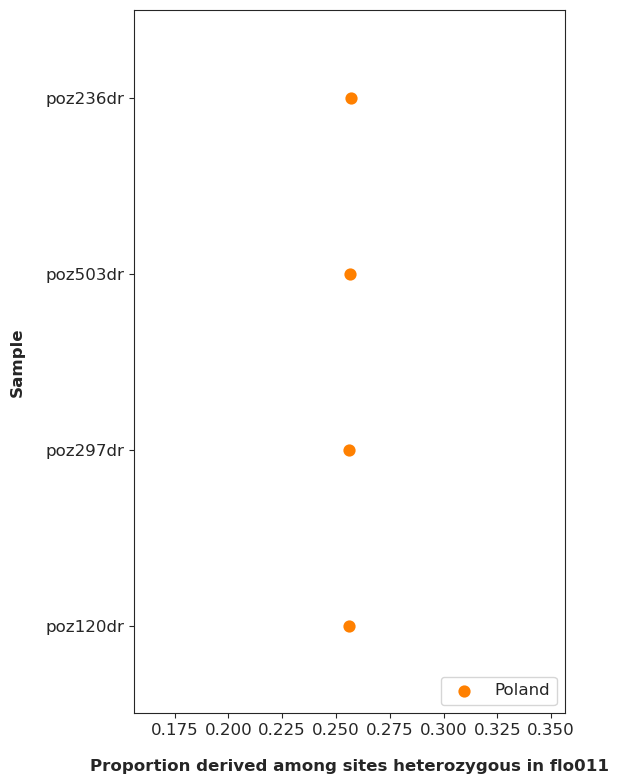

In [1060]:
fig, ax = plt.subplots(figsize=(6,8))

# really hacky way to do error bars - plotting under the sns plot with invisible markers
a = data1_in['wbj_mean']
b = data1_in['sample']
c = data1_in['wbj_errors']
ax.errorbar(a, b, xerr=c, fmt='none', ecolor='grey', zorder=0)

ax = sns.pointplot(x='wbj_mean', y='sample', data=data1_in, hue='Groups', hue_order=group_order[idx:idx+1], join=False, palette=palette, zorder=1)
ax.ticklabel_format(style='plain', axis='x')

plt.xlabel("Proportion derived among sites heterozygous in {}".format(anchor),fontweight ='bold', size=12, labelpad=15)
plt.ylabel("Sample",fontweight ='bold', size=12, labelpad=15)
plt.legend(loc='lower right')
lower, upper = [data1_in['wbj_mean'].mean()-0.1, data1_in['wbj_mean'].mean()+0.1]
ax.set_xlim(lower, upper)
#ax.get_legend().remove()
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Anchor_{}_dr_{}.png'.format(anchor, region), dpi=300)

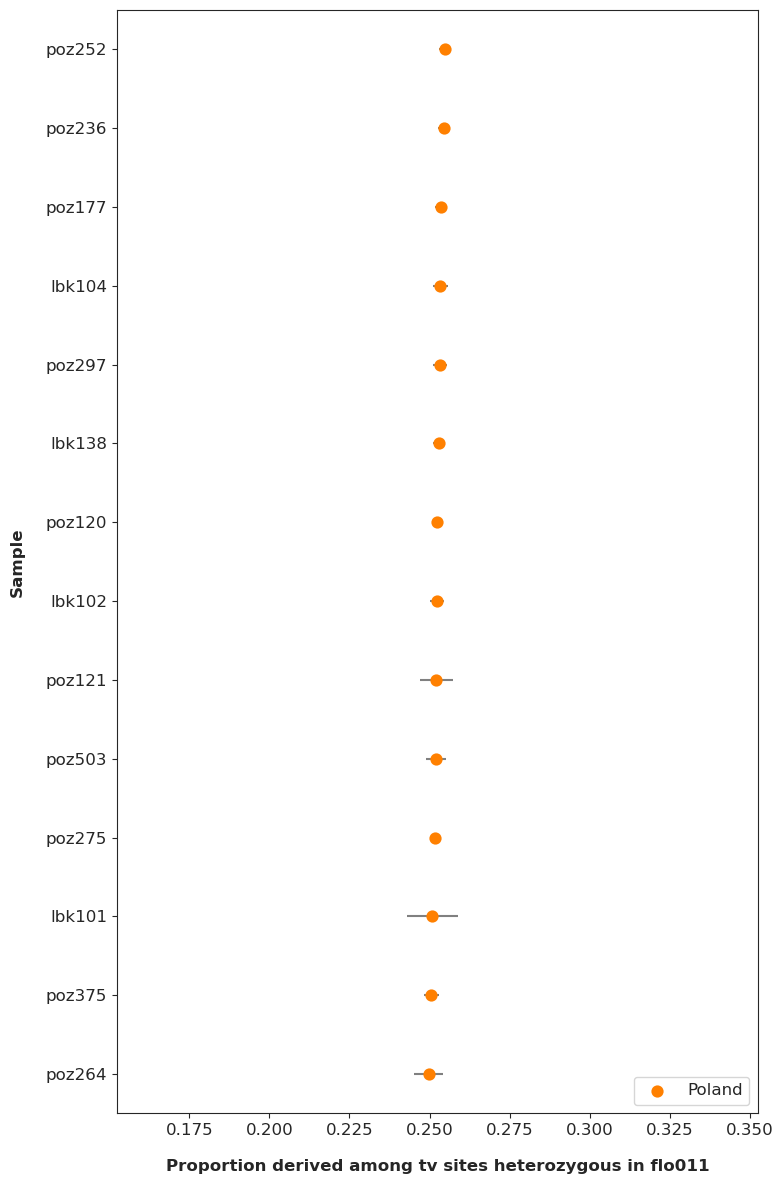

In [1061]:
fig, ax = plt.subplots(figsize=(8,12))

# really hacky way to do error bars - plotting under the sns plot with invisible markers
a = data2_in['wbj_mean']
b = data2_in['sample']
c = data2_in['wbj_errors']
ax.errorbar(a, b, xerr=c, fmt='none', ecolor='grey', zorder=0)

ax = sns.pointplot(x='wbj_mean', y='sample', data=data2_in, hue='Groups', hue_order=group_order[idx:idx+1], join=False, palette=palette, zorder=1)
ax.ticklabel_format(style='plain', axis='x')

plt.xlabel("Proportion derived among tv sites heterozygous in {}".format(anchor),fontweight ='bold', size=12, labelpad=15)
plt.ylabel("Sample",fontweight ='bold', size=12, labelpad=15)
plt.legend(loc='lower right')
lower, upper = [data2_in['wbj_mean'].mean()-0.1, data2_in['wbj_mean'].mean()+0.1]
ax.set_xlim(lower, upper)
#ax.get_legend().remove()
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Anchor_{}_be_{}.png'.format(anchor, region), dpi=300)
                             

## Repeat but sort by time

In [1062]:
data1_in = data1_in.sort_values(['Ages'], ascending=False)
data2_in = data2_in.sort_values(['Ages'], ascending=False)

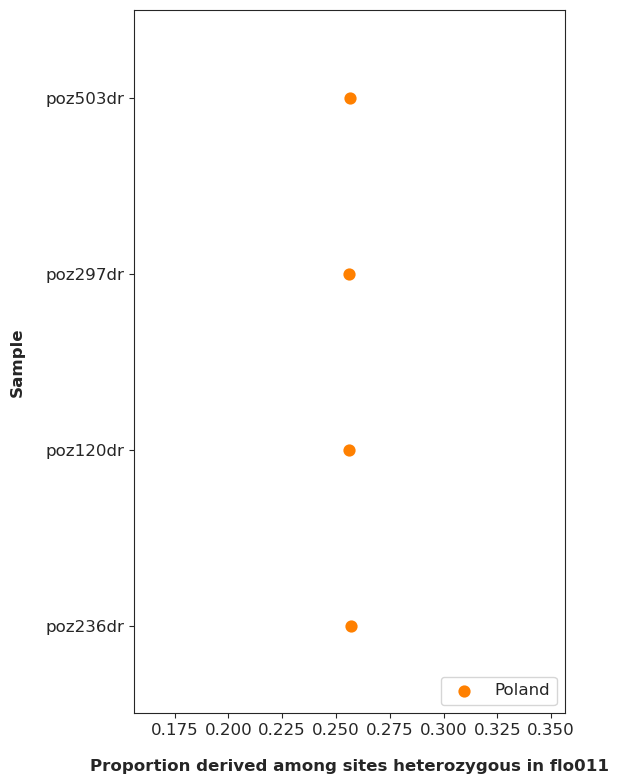

In [1063]:
fig, ax = plt.subplots(figsize=(6,8))

# really hacky way to do error bars - plotting over the top of the sns plot with invisible markers
a = data1_in['wbj_mean']
b = data1_in['sample']
c = data1_in['wbj_errors']
ax.errorbar(a, b, xerr=c, fmt='none', ecolor='grey', zorder=0)

ax = sns.pointplot(x='wbj_mean', y='sample', data=data1_in, hue='Groups', hue_order=group_order[idx:idx+1], join=False, palette=palette, zorder=1)
ax.ticklabel_format(style='plain', axis='x')

plt.xlabel("Proportion derived among sites heterozygous in {}".format(anchor),fontweight ='bold', size=12, labelpad=15)
plt.ylabel("Sample",fontweight ='bold', size=12, labelpad=15)
plt.legend(loc='lower right')
lower, upper = [data1_in['wbj_mean'].mean()-0.1, data1_in['wbj_mean'].mean()+0.1]
ax.set_xlim(lower, upper)
#ax.get_legend().remove()
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Anchor_{}_dr_{}_AgeSorted.png'.format(anchor, region), dpi=300)
    

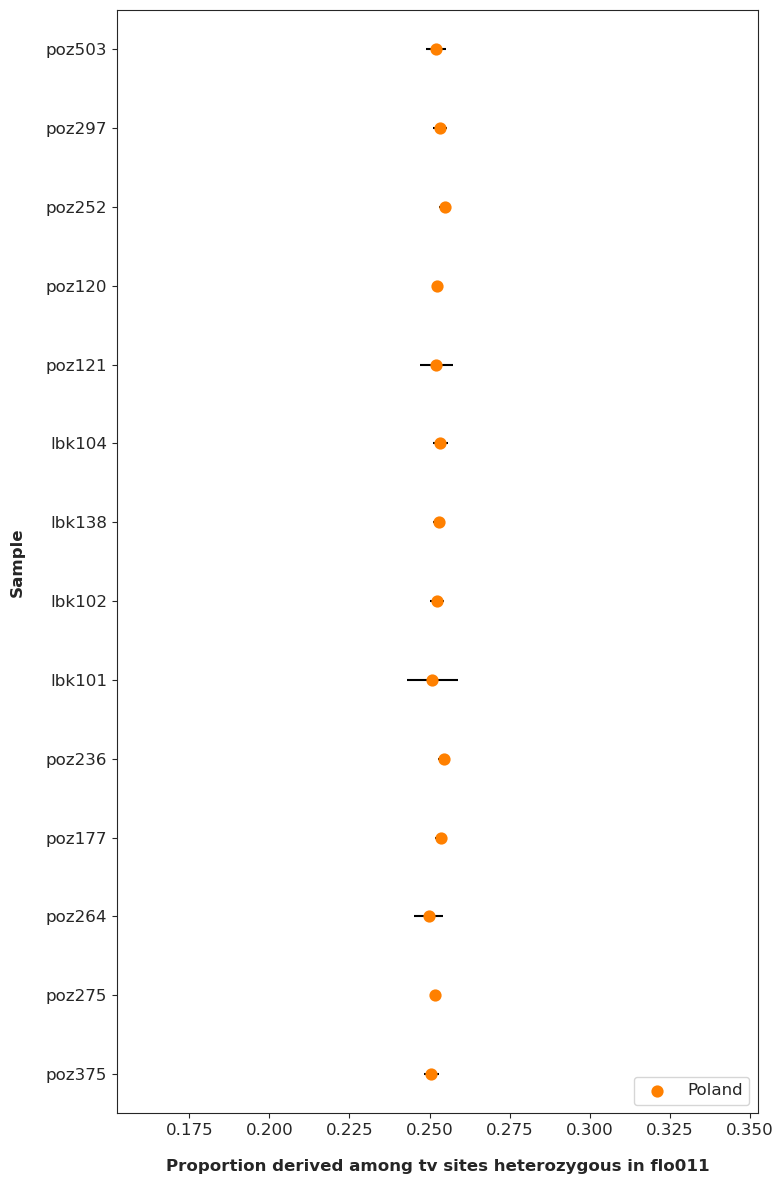

In [1064]:
fig, ax = plt.subplots(figsize=(8,12))

# really hacky way to do error bars - plotting over the top of the sns plot with invisible markers
a = data2_in['wbj_mean']
b = data2_in['sample']
c = data2_in['wbj_errors']
ax.errorbar(a, b, xerr=c, fmt='none', ecolor='black', zorder=0)

ax = sns.pointplot(x='wbj_mean', y='sample', data=data2_in, hue='Groups', hue_order=group_order[idx:idx+1], join=False, palette=palette, zorder=1)
ax.ticklabel_format(style='plain', axis='x')

plt.xlabel("Proportion derived among tv sites heterozygous in {}".format(anchor),fontweight ='bold', size=12, labelpad=15)
plt.ylabel("Sample",fontweight ='bold', size=12, labelpad=15)
plt.legend(loc='lower right')
lower, upper = [data2_in['wbj_mean'].mean()-0.1, data2_in['wbj_mean'].mean()+0.1]
ax.set_xlim(lower, upper)
#ax.get_legend().remove()
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Anchor_{}_be_{}_AgeSorted.png'.format(anchor, region), dpi=300)
    

In [ ]:
# Repeat, but with a plot for each region instead

In [ ]:
time = {"BallitoBayA":2000,"ElandsBayCave":,"flo001":,"flo003":,
          "flo006":,"flo011":,"Mfongosi":,"Karretjie":0,"Juhoansi":0,"Nama"0,"Xun":0,"French":0,
          "Sardinian":0,"Han":0,"Mandenka":0,"Biaka":0,"Yoruba":0,
          "Luhya":0,"Mende":0,"Ju-hoan-North":0,"Dinka":0,"Mbuti":0,"Khomani-San":0,"Dai":0,"Mota":0,"Newcastle":0,
          "ShumLaka":0,"Newcastle":}



In [ ]:
fig, ax = plt.subplots(figsize=(8,7))
ax = sns.pointplot(x='wbj_mean', y='sample', data=df1_sorted, hue='Groups', hue_order=group_order, join=False, palette=palette)
ax.ticklabel_format(style='plain', axis='x')

# really hacky way to do error bars - plotting over the top of the sns plot with invisible markers
a = df1_sorted['wbj_mean']
b = df1_sorted['sample']
c = df1_sorted['wbj_errors']
ax.errorbar(a, b, xerr=c, fmt='none', ecolor='black')

plt.xlabel("Proportion derived among sites heterozygous in flo006",fontweight ='bold', size=12, labelpad=15)
plt.ylabel("Sample",fontweight ='bold', size=12, labelpad=15)
plt.legend(loc='lower right')
ax.set_xlim(0.06, 0.14)
#ax.get_legend().remove()
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Anchor_flo006_grouped.png', dpi=300)

/tmp/ipykernel_23082/1129897199.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sterr = list(1.96*(df1_sorted['wbj_errors'][:-1]))


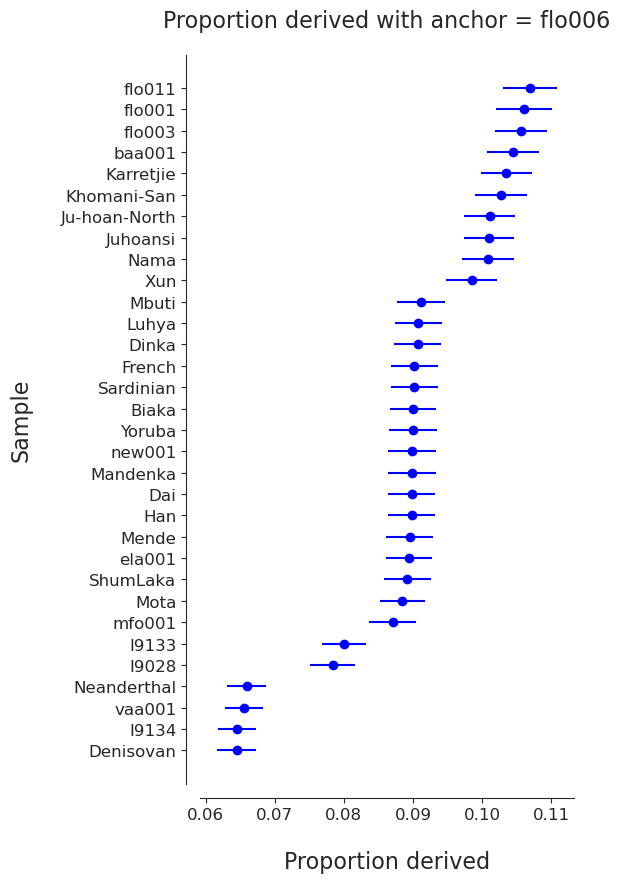

In [18]:
# Define function to plot proportion derived vs inds on x axis. 
y = df1_sorted['wbj_mean'].tolist()[:-1]
sterr = list(1.96*(df1_sorted['wbj_errors'][:-1]))
#x = df1_sorted['sample'].map(edit_names).tolist() # if you want to edit names above
x = df1_sorted['sample'].tolist()[:-1]
fig, ax = plt.subplots(figsize=(6, 9))
sns.despine(ax=ax, offset=10)
ax.errorbar(y, x, xerr=sterr, marker='o', ecolor="blue", label="TRB", linestyle = 'None', markeredgecolor='blue', markerfacecolor='blue')

ax.set_ylabel('Sample', labelpad=20)
ax.set_xlabel('Proportion derived', labelpad=20)
#ax.set_xlim(0.15, 0.35)
ax.set_title('Proportion derived with anchor = {}'.format(anchor), pad=20)

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1], title='Group', loc=2)
  
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(16)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)        
fig.tight_layout()
#if isSaveFigures:
#    plt.savefig('DIR_plots/'+anchor+'/'+anchor+'_anchor_plot.pdf', dpi=300) 

In [ ]:
########################################

In [160]:
df2 = pd.read_csv(outPATH+anchor+'_prop_der_transversion.res', sep="\t")
df2['wbj_errors']=2.0*np.sqrt(df2['wbj_var'])
df2_sorted = df2.sort_values(['wbj_mean'], ascending=True)

/tmp/ipykernel_6029/1847566715.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sterr = list(1.96*(df2_sorted['wbj_errors'][:-1]))


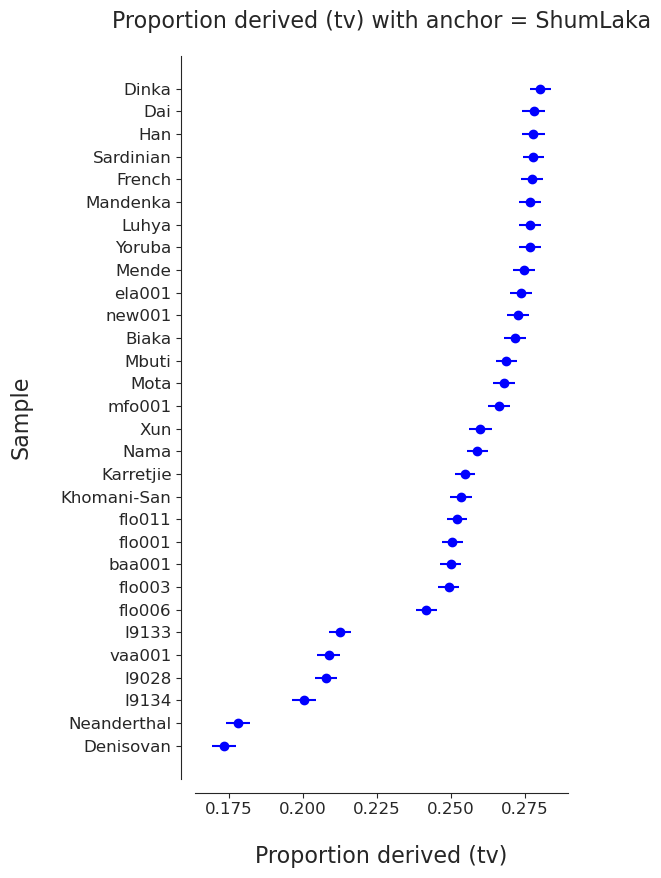

In [161]:
# Define function to plot proportion derived vs inds on x axis. 
y = df2_sorted['wbj_mean'].tolist()[:-1]
sterr = list(1.96*(df2_sorted['wbj_errors'][:-1]))
#x = df2_sorted['sample'].map(edit_names).tolist() # if you want to edit names above
x = df2_sorted['sample'].tolist()[:-1]
fig, ax = plt.subplots(figsize=(6, 9))
sns.despine(ax=ax, offset=10)
ax.errorbar(y, x, xerr=sterr, marker='o', ecolor="blue", label="TRB", linestyle = 'None', markeredgecolor='blue', markerfacecolor='blue')

ax.set_ylabel('Sample', labelpad=20)
ax.set_xlabel('Proportion derived (tv)', labelpad=20)
#ax.set_xlim(0.15, 0.35)
ax.set_title('Proportion derived (tv) with anchor = {}'.format(anchor), pad=20)

handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1], title='Group', loc=2)
  
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(16)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)        
fig.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/'+anchor+'/'+anchor+'_anchor_plot_tv.pdf', dpi=300) 

/tmp/ipykernel_9518/2984360149.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sterr1 = list(1.96*(df1_sorted['wbj_errors'][0:5]))
/tmp/ipykernel_9518/2984360149.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sterr2 = list(1.96*(df1_sorted['wbj_errors'][5:10]))


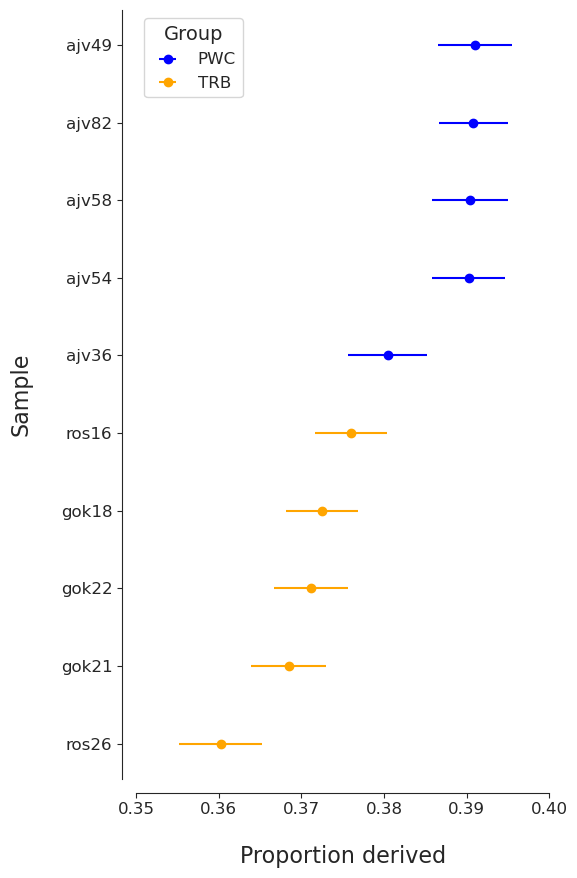

In [42]:
# Define function to plot proportion derived vs inds on x axis. 
y1 = df1_sorted['wbj_mean'].tolist()[0:5]
y2 = df1_sorted['wbj_mean'].tolist()[5:10]
sterr1 = list(1.96*(df1_sorted['wbj_errors'][0:5]))
sterr2 = list(1.96*(df1_sorted['wbj_errors'][5:10]))
x1 = df1_sorted['sample'].map(edit_names).tolist()[0:5]
x2 = df1_sorted['sample'].map(edit_names).tolist()[5:10]
fig, ax = plt.subplots(figsize=(6, 9))
sns.despine(ax=ax, offset=10)
ax.errorbar(y1, x1, xerr=sterr1, marker='o', ecolor="orange", label="TRB", linestyle = 'None', markeredgecolor='orange', markerfacecolor='orange')
ax.errorbar(y2, x2, xerr=sterr2, marker='o', ecolor="blue", label="PWC", linestyle = 'None', markeredgecolor='blue', markerfacecolor='blue')

ax.set_ylabel('Sample', labelpad=20)
ax.set_xlabel('Proportion derived', labelpad=20)
ax.set_xlim(0.35, 0.40)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Group', loc=2)
  
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(16)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)        
fig.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/sf12_anchor_plot.pdf', dpi=300) 

In [194]:
# drop index 19 then change sample names
df1_sorted

,sample,obs_mean,wbj_mean,wbj_var,wbj_errors
10,ros026DR,0.360218,0.360218,1.608982e-06,0.002537
13,gok021DR,0.368465,0.368465,1.335935e-06,0.002312
34,gok022DR,0.371159,0.371159,1.319164e-06,0.002297
21,gok018DR,0.372461,0.372461,1.246057e-06,0.002233
8,ros016DR,0.375980,0.375980,1.216170e-06,0.002206
32,ans017DR,0.377722,0.377722,1.257076e-06,0.002242
24,ajv036DR,0.380461,0.380461,1.492491e-06,0.002443
7,ajv058DR-downsampled,0.386256,0.386256,3.439699e-06,0.003709
30,ajv054DR,0.390213,0.390213,1.276649e-06,0.002260
15,ajv058DR,0.390375,0.390375,1.374817e-06,0.002345


### Plot proportion derived of anchor transitions

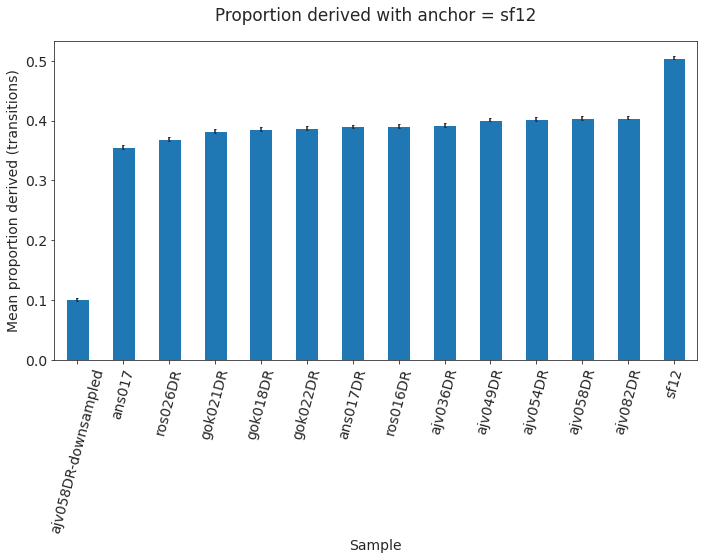

In [44]:
df2 = pd.read_csv(outPATH+anchor+'_prop_der_transition.res', sep="\t")
df2['wbj_errors']=2.0*np.sqrt(df2['wbj_var'])
df2_sorted = df2.sort_values(['wbj_mean'], ascending=True)

if anchor in transbaikal_sample_list:  # subset df to just one set of samples or the other
    df2_sorted = df2_sorted.loc[df2_sorted['sample'].isin(transbaikal_sample_list)]
else:
    df2_sorted = df2_sorted.loc[df2_sorted['sample'].isin(scandi_sample_list)]

df2_sorted.plot(kind='bar', x='sample', y='wbj_mean', legend=False, yerr='wbj_errors', capsize=1, rot=75)
plt.title('Proportion derived with anchor = {}'.format(anchor), pad=20)
plt.ylabel("Mean proportion derived (transitions)")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.52])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/'+anchor+'_prop_der_transitions_Scandis.pdf')

### Plot proportion derived of anchor transversions

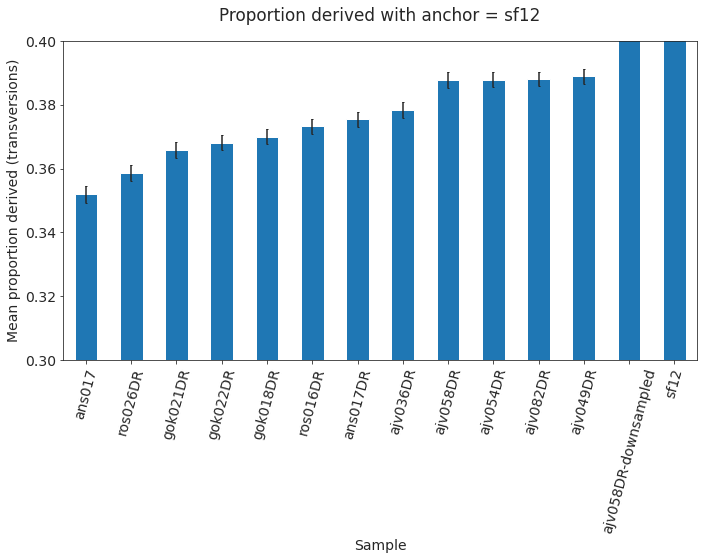

In [46]:
df3 = pd.read_csv(outPATH+anchor+'_prop_der_transversion.res', sep="\t")
df3['wbj_errors']=2.0*np.sqrt(df3['wbj_var'])
df3_sorted = df3.sort_values(['wbj_mean'], ascending=True)

if anchor in transbaikal_sample_list: # subset df to just one set of samples or the other
    df3_sorted = df3_sorted.loc[df3_sorted['sample'].isin(transbaikal_sample_list)]
else:
    df3_sorted = df3_sorted.loc[df3_sorted['sample'].isin(scandi_sample_list)]

df3_sorted.plot(kind='bar', x='sample', y='wbj_mean', legend=False, yerr='wbj_errors', capsize=1, rot=75)
plt.title('Proportion derived with anchor = {}'.format(anchor), pad=20)
plt.ylabel("Mean proportion derived (transversions)")
plt.xlabel("Sample")
plt.ylim([0.30, 0.40])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/'+anchor+'_prop_der_transversions_Scandis.pdf')

### Load in the proportion derived of anchors against themselves, for all heterozygous sites, transitions and transversion sites

In [450]:
self_anchor_all_dict = {'Ju-hoan-North':0.495398,'baa001':0.488018,'UstIshim':0.498817,'kotias':0.49970,'Loschbour':0.496792,
              'sf12':0.498835,'ans017':0.498183,'Mbuti':0.495624,'H-Mbuti':0.497709,'H-San':0.497426,'Neanderthal':0.496828,'Denisovan':0.494723}
self_anchor_all_df = pd.DataFrame.from_dict(self_anchor_all_dict, orient='index', columns=['mean_prop_derived_all']).sort_values(['mean_prop_derived_all'], ascending=True)

self_anchor_ts_dict = {'Ju-hoan-North':0.493431,'baa001':0.514590,'UstIshim':0.499837,'kotias':0.495605,'Loschbour':0.504352,
              'sf12':0.503687,'ans017':0.470171,'Mbuti':0.495501,'H-Mbuti':0.496000,'H-San':0.495551,'Neanderthal':0.495148,'Denisovan':0.496204}
self_anchor_ts_df = pd.DataFrame.from_dict(self_anchor_ts_dict, orient='index', columns=['mean_prop_derived_ts']).sort_values(['mean_prop_derived_ts'], ascending=True)

self_anchor_tv_dict = {'Ju-hoan-North':0.495758 ,'baa001':0.483287,'UstIshim':0.498629,'kotias':0.500417,'Loschbour':0.507721,
              'sf12':0.497942,'ans017':0.502444,'Mbuti':0.495647,'H-Mbuti':0.498026,'H-San':0.497772,'Neanderthal':0.497138,'Denisovan':0.494463}
self_anchor_tv_df = pd.DataFrame.from_dict(self_anchor_tv_dict, orient='index', columns=['mean_prop_derived_tv']).sort_values(['mean_prop_derived_tv'], ascending=True)


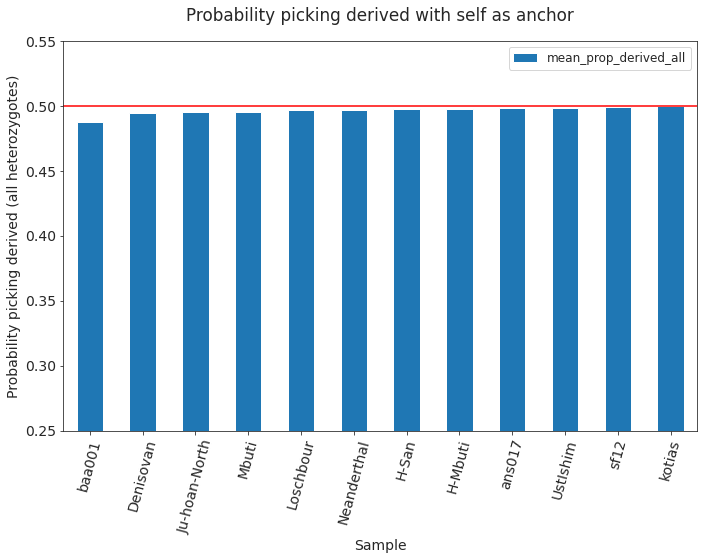

In [515]:
self_anchor_all_df.plot(kind='bar', y='mean_prop_derived_all', capsize=1, rot=75)
plt.title('Probability picking derived with self as anchor', pad=20)
plt.ylabel("Probability picking derived (all heterozygotes)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.55])
plt.axhline(y=0.5, color='r', linestyle='-')
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/prob_der_anchors_self_All.pdf')

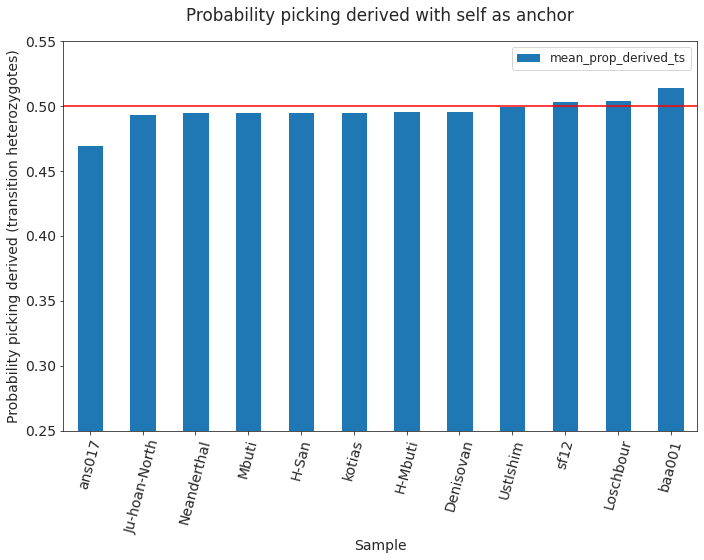

In [516]:
self_anchor_ts_df.plot(kind='bar', y='mean_prop_derived_ts', capsize=1, rot=75)
plt.title('Probability picking derived with self as anchor', pad=20)
plt.ylabel("Probability picking derived (transition heterozygotes)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.55])
plt.axhline(y=0.5, color='r', linestyle='-')
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/prob_der_anchors_self_ts.pdf')

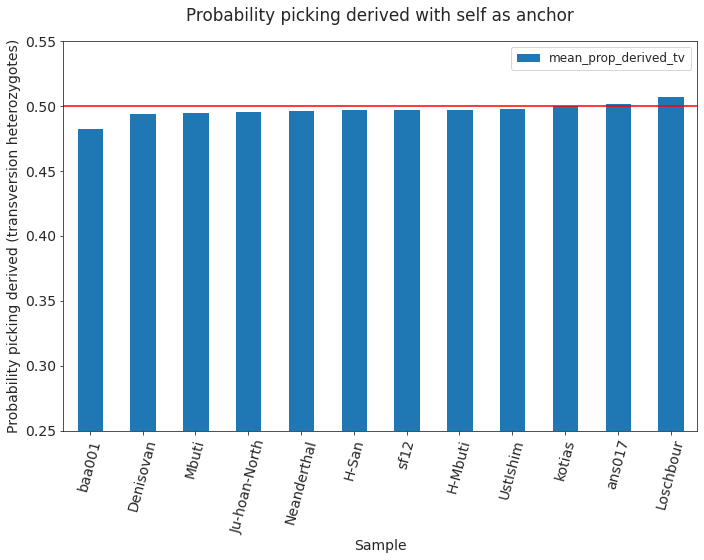

In [517]:
self_anchor_tv_df.plot(kind='bar', y='mean_prop_derived_tv', capsize=1, rot=75)
plt.title('Probability picking derived with self as anchor', pad=20)
plt.ylabel("Probability picking derived (transversion heterozygotes)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.55])
plt.axhline(y=0.5, color='r', linestyle='-')
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/prob_der_anchors_self_tv.pdf')

# Load in summary statistics calculated per chromosome
### Estimating means of each summary statistic, resulting df added manually to "Metadata.csv"

In [44]:
# get mean f2(baa001,X)
# Get CSV files list from a folder
inPATH = 'Sumstats/'
temp=os.listdir(inPATH)

In [21]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('f2_baa'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
f2_baa001_df = pd.concat(df_list).groupby("Unnamed: 0").mean("mean_f2")

In [22]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('f2_Den'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
f2_Denisovan_df = pd.concat(df_list).groupby("Unnamed: 0").mean("mean_f2")

In [23]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('f2_Nea'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
f2_Neanderthal_df = pd.concat(df_list).groupby("Unnamed: 0").mean("mean_f2")

In [24]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('f3_Den'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
f3_Denisovan_df = pd.concat(df_list).groupby("Unnamed: 0").mean("mean_f3")

In [25]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('unnormed_f3_Den'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
unnormed_f3_Denisovan_df = pd.concat(df_list).groupby("Unnamed: 0").mean("mean_f3_unnormed")


In [26]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('f3_Nea'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
f3_Neanderthal_df = pd.concat(df_list).groupby("Unnamed: 0").mean("mean_f3")

In [27]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('unnormed_f3_Nea'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
unnormed_f3_Neanderthal_df = pd.concat(df_list).groupby("Unnamed: 0").mean("mean_f3_unnormed")


In [28]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('sample_sumstats'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
sample_sumstats_df = pd.concat(df_list).groupby("Unnamed: 0").mean("mean_sumstats")

In [29]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('freqstat_baa001'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
freqstat_baa001_df = pd.concat(df_list).groupby("Unnamed: 0").mean("mean_freq_stat")

In [30]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('freqstat_Neanderthal'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
freqstat_Neanderthal_df = pd.concat(df_list).groupby("Unnamed: 0").mean("mean_freq_stat")

In [31]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('freqstat_Denisovan'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
freqstat_Denisovan_df = pd.concat(df_list).groupby("Unnamed: 0").mean("mean_freq_stat")

In [45]:
# get list of relevant csv files
csv_files = []
for file in temp:
    if file.startswith('f4test'):
        csv_files.append(file)

# Read each CSV file into DataFrame
df_list = (pd.read_csv(inPATH+file) for file in csv_files) # create a list of dataframes
# Concatenate all DataFrames and groupby comparisons to get mean across chromosomes
f4test_df = pd.concat(df_list).groupby("test").mean("mean_d")
# plot some variables from the table: f2(baa001, X), mReadLength, averageDP etc
f4_sorted = f4test_df.sort_values(['mean_d'], ascending=True)
f4_sorted = f4_sorted.reset_index(level=0)
# drop some samples
f4_sorted.drop(index=[4], inplace=True) # Dropping Loschbour
f4_sorted.drop(index=[7], inplace=True) # Dropping ans17
#f4_sorted.drop(index=[6], inplace=True) # Dropping ajv58-downsampled
f4_sorted.drop(index=[10], inplace=True) # Dropping UstIshim

In [58]:
f4_sorted.drop(index=[6], inplace=True) # Dropping ajv58-downsampled

In [59]:
f4_sorted

,test,mean_d,mean_se,mean_z
0,ajv082DR,-0.122297,0.020447,-6.216553
1,ajv049DR,-0.120266,0.020351,-6.158265
2,ajv058DR,-0.118544,0.020716,-6.041837
3,ajv054DR,-0.114879,0.020632,-5.833105
5,ajv036DR,-0.094800,0.020829,-4.787380
8,gok022DR,-0.000052,0.020386,0.006706
9,gok018DR,0.009396,0.020746,0.544698
11,ros016DR,0.010184,0.020654,0.622374
12,ros026DR,0.013870,0.020618,0.684005
13,gok021DR,0.017724,0.020433,0.890185


In [57]:
f4_sorted['test'].map(edit_names).tolist()[0:6]

['ajv82', 'ajv49', 'ajv58', 'ajv54', 'ajv36', nan]

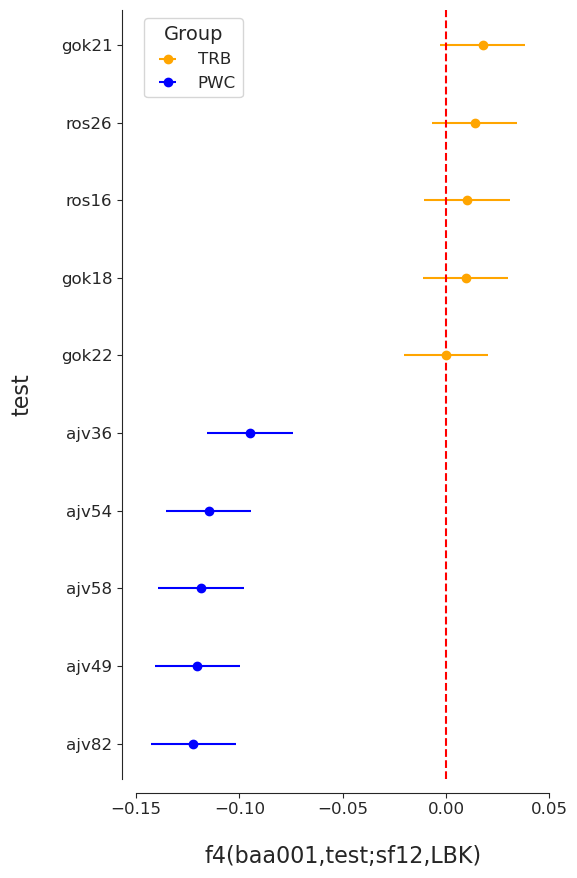

In [60]:
# Define function to plot proportion derived vs inds on x axis. 
y1 = f4_sorted['mean_d'].tolist()[0:5]
y2 = f4_sorted['mean_d'].tolist()[5:10]
sterr1 = f4_sorted['mean_se'].tolist()[0:5]
sterr2 = f4_sorted['mean_se'].tolist()[5:10]
x1 = f4_sorted['test'].map(edit_names).tolist()[0:5]
x2 = f4_sorted['test'].map(edit_names).tolist()[5:10]

fig, ax = plt.subplots(figsize=(6, 9))
sns.despine(ax=ax, offset=10)
ax.errorbar(y1, x1, xerr=sterr1, marker='o', ecolor="blue", label="PWC", linestyle = 'None', markeredgecolor='blue', markerfacecolor='blue')
ax.errorbar(y2, x2, xerr=sterr2, marker='o', ecolor="orange", label="TRB", linestyle = 'None', markeredgecolor='orange', markerfacecolor='orange')
ax.axvline(x=0.0, color='r', linestyle='--')

ax.set_ylabel('test', labelpad=20)
ax.set_xlabel('f4(baa001,test;sf12,LBK)', labelpad=20)
ax.set_xlim(-0.15, 0.05)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Group', loc=2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(16)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)        
fig.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/f4_meand.pdf', dpi=300) 

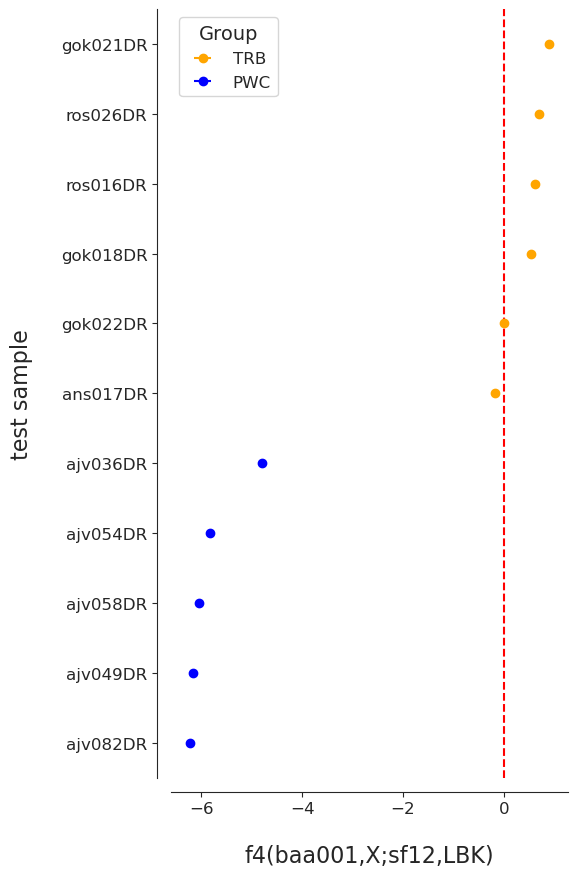

In [81]:
# Define function to plot proportion derived vs inds on x axis. 
y1 = f4_sorted['mean_z'].tolist()[0:5]
y2 = f4_sorted['mean_z'].tolist()[5:11]
sterr1 = f4_sorted['mean_se'].tolist()[0:5]
sterr2 = f4_sorted['mean_se'].tolist()[5:11]
x1 = f4_sorted['test'].tolist()[0:5]
x2 = f4_sorted['test'].tolist()[5:11]

fig, ax = plt.subplots(figsize=(6, 9))
sns.despine(ax=ax, offset=10)
ax.errorbar(y1, x1, xerr=sterr1, marker='o', ecolor="blue", label="PWC", linestyle = 'None', markeredgecolor='blue', markerfacecolor='blue')
ax.errorbar(y2, x2, xerr=sterr2, marker='o', ecolor="orange", label="TRB", linestyle = 'None', markeredgecolor='orange', markerfacecolor='orange')
ax.axvline(x=0.0, color='r', linestyle='--')

ax.set_ylabel('test sample', labelpad=20)
ax.set_xlabel('f4(baa001,X;sf12,LBK)', labelpad=20)
#ax.set_xlim(-0.15, 0.05)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Group', loc=2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(16)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)        
fig.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/f4_meanz.pdf', dpi=300) 

In [ ]:
# Define function to plot proportion derived vs inds on x axis. 
y1 = df1_sorted['wbj_mean'].tolist()[0:6]
y2 = df1_sorted['wbj_mean'].tolist()[6:12]
sterr1 = list(1.96*(df1_sorted['wbj_errors'][0:6]))
sterr2 = list(1.96*(df1_sorted['wbj_errors'][6:12]))
x1 = df1_sorted['sample'].map(edit_names).tolist()[0:6]
x2 = df1_sorted['sample'].map(edit_names).tolist()[6:12]
fig, ax = plt.subplots(figsize=(6, 9))
sns.despine(ax=ax, offset=10)
ax.errorbar(y1, x1, xerr=sterr1, marker='o', ecolor="orange", label="TRB", linestyle = 'None', markeredgecolor='orange', markerfacecolor='orange')
ax.errorbar(y2, x2, xerr=sterr2, marker='o', ecolor="blue", label="PWC", linestyle = 'None', markeredgecolor='blue', markerfacecolor='blue')

ax.set_ylabel('Sample', labelpad=20)
ax.set_xlabel('Proportion derived', labelpad=20)
ax.set_xlim(0.35, 0.40)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Group', loc=2)
  
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(16)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)        
fig.tight_layout()
#if isSaveFigures:
#    plt.savefig('DIR_plots/sf12_anchor_plot.pdf', dpi=300) 

# Load in whole stats file

In [562]:
# All above stats transcribed into Metadata.csv table (TODO: avoid this), then load in Metadata table as df
stats_df = pd.read_csv('Metadata.csv')
stats_df.rename(columns={"Sample":"sample"}, inplace=True) # edit a column heading so we can merge based on "sample" ID
# add some variables to the table the table: f2(baa001, X), mReadLength, averageDP etc
stats_df['PropNonRefHom']=stats_df['nNonRefHom'] / ( stats_df['nNonRefHom'] + stats_df['nRefHom'] + stats_df['nHets'] )
stats_df['PropRefHom']=stats_df['nRefHom'] / ( stats_df['nNonRefHom'] + stats_df['nRefHom'] + stats_df['nHets'] )
stats_df['PropHets']=stats_df['nHets'] / ( stats_df['nNonRefHom'] + stats_df['nRefHom'] + stats_df['nHets'] )

In [563]:
# add columns for the all sites, transitions, transversions 
anchor_baa001_all = df1_sorted[:-1].copy(deep=True)
stats_df = pd.merge(stats_df,anchor_baa001_all[['sample','wbj_mean']], on="sample", how = 'left')
stats_df.rename(columns={"wbj_mean":"baa001_anchor_prop_der_all"}, inplace=True)

anchor_baa001_ts = df2_sorted[:-1].copy(deep=True)
stats_df = pd.merge(stats_df,anchor_baa001_ts[['sample','wbj_mean']], on="sample", how = 'left')
stats_df.rename(columns={"wbj_mean":"baa001_anchor_prop_der_ts"}, inplace=True)

anchor_baa001_tv = df3_sorted[:-1].copy(deep=True)
stats_df = pd.merge(stats_df,anchor_baa001_tv[['sample','wbj_mean']], on="sample", how = 'left')
stats_df.rename(columns={"wbj_mean":"baa001_anchor_prop_der_tv"}, inplace=True)

In [547]:
stats_df

,sample,nRefHom,nNonRefHom,nHets,nTransitions,nTransversions,ts/tv ratio,averageDP,nSingletons,nMissing,...,HeterozygosityObs,"freq(baa,X)","freq(Denisovan,X)","freq(Neanderthal,X)",PropNonRefHom,PropRefHom,PropHets,baa001_anchor_prop_der_all,baa001_anchor_prop_der_ts,baa001_anchor_prop_der_tv
0,ajv58,2343031667,17614969,1668390,16316588,2966771,5.499780,3.213636,14382849,276311119,...,0.007250,0.007191,0.007268,0.007359,0.007457,0.991837,0.000706,0.223491,0.175528,0.233554
1,ans008,2026078292,33595115,1255194,32250335,2599974,12.404099,2.672727,28311572,577697544,...,0.017100,0.006732,0.006752,0.006842,0.016301,0.983090,0.000609,0.224948,0.146647,0.244023
2,ans014,2398746784,14450851,2194584,14655822,1989613,7.366167,3.577273,11972492,223233926,...,0.006470,0.007222,0.007294,0.007352,0.005983,0.993109,0.000909,0.221871,0.185274,0.229222
3,ans017,2591173897,3442904,1319432,3411146,1351190,2.524549,7.445455,1555353,42689912,...,0.010500,0.007264,0.007317,0.007369,0.001326,0.998165,0.000508,0.228603,0.244700,0.225761
4,Bichon,2584991392,2720772,3351876,4060385,2012263,2.017820,15.181818,2677990,47562105,...,0.043814,0.007499,0.007584,0.007686,0.001050,0.997656,0.001294,NaN,NaN,NaN
5,brn001,2535202980,3666984,9902766,10822956,2746794,3.940214,1.100000,8983575,89853415,...,0.000288,0.004264,0.004286,0.004319,0.001439,0.994676,0.003885,0.243515,0.187650,0.256269
6,brn002,273317403,7385658,4930,3866662,3523926,1.097260,1.200000,6309812,2357918154,...,0.000513,0.005970,0.006022,0.006085,0.026311,0.973672,0.000018,0.232332,0.112870,0.263949
7,brn003,738242734,20772787,62115,15374445,5460457,2.815597,4.304545,17501366,1879548509,...,0.006150,0.007574,0.007666,0.007739,0.027366,0.972552,0.000082,0.223505,0.234152,0.221589
8,brn008,2548299210,6080283,835759,4607434,2308608,1.995763,2.895455,3591961,83410893,...,0.003740,0.007539,0.007570,0.007632,0.002380,0.997293,0.000327,0.225965,0.213570,0.228457
9,cta016,2320815755,16696893,813532,15681722,1828703,8.575325,5.150000,12664996,300299965,...,0.008940,0.007689,0.007783,0.007864,0.007141,0.992512,0.000348,0.226984,0.237119,0.225146


In [568]:
# Save Pandas dataframe down to file
stats_df.drop(index=[4,11], inplace=True) # Drop problematic samples Bichon and irk078 (20% contamination)
stats_df.to_csv('DIR_estimates/Anchor_sumstats_res.csv', index=False)

# Starting from here; load in the prepared Sumstats dataset

In [294]:
# load in the saved datsest
stats_df = pd.read_csv('DIR_estimates/Anchor_sumstats_res.csv')

In [295]:
for x in stats_df.columns.tolist():
    print(x)

sample
nRefHom
nNonRefHom
nHets
nTransitions
nTransversions
ts/tv ratio
averageDP
nSingletons
nMissing
Sample_time
Contamination
mReadLength
f2(baa001,X)
f2(Denisovan,X)
f2(Neanderthal,X)
f3(Denisovan;baa001,X)
f3(Neanderthal;baa001,X)
unnormed_f3(Denisovan;baa001,X)
unnormed_f3(Neanderthal;baa001,X)
SequenceDiversity
SegSites
HeterozygosityObs
freq(baa,X)
freq(Denisovan,X)
freq(Neanderthal,X)
PropNonRefHom
PropRefHom
PropHets
baa001_anchor_prop_der_all
baa001_anchor_prop_der_ts
baa001_anchor_prop_der_tv


# Plot some variables to see if they are correlated

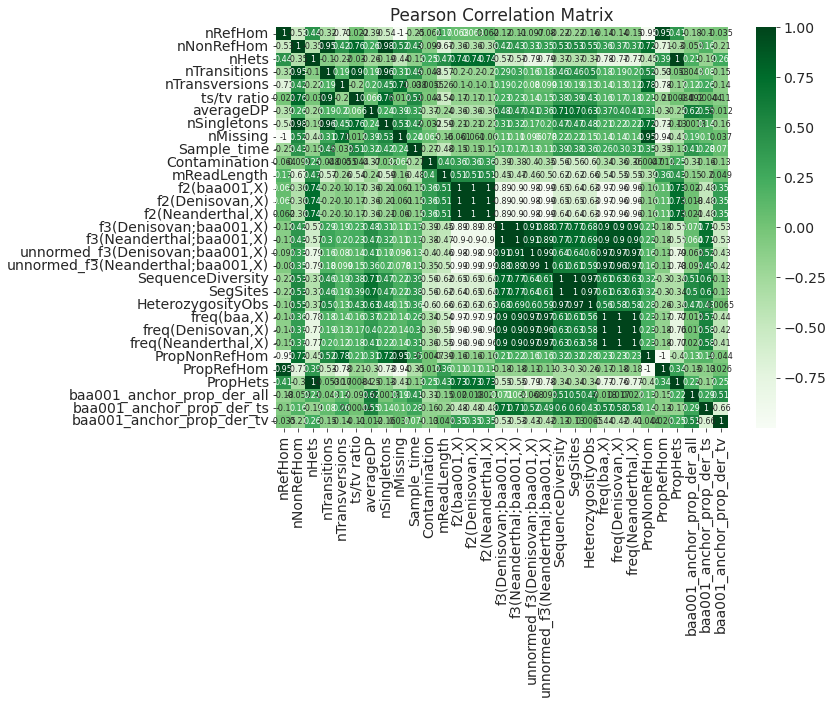

In [296]:
# Plot Pearson correlation matrix
fig_1 = plt.figure(figsize=(12, 10))
new_correlations = stats_df.corr()
sns.heatmap(new_correlations, annot=True, cmap='Greens', annot_kws={'size': 8})
plt.title('Pearson Correlation Matrix')
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/'+anchor+'_CorrelationMatrix_All.pdf')

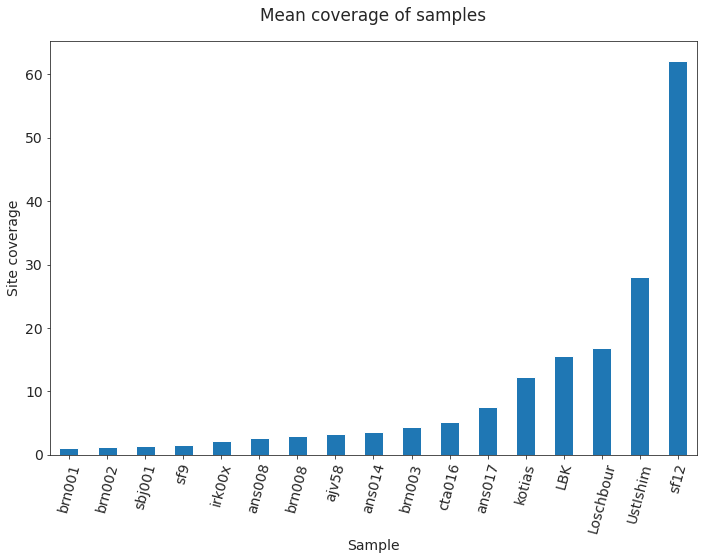

In [297]:
# plot some variables from the table: f2(baa001, X), mReadLength, averageDP etc
cov_sorted = stats_df.sort_values(['averageDP'], ascending=True)
cov_sorted.plot(kind='bar', x='sample', y='averageDP', legend=False, capsize=1, rot=75)
plt.title('Mean coverage of samples', pad=20)
plt.ylabel("Site coverage")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/averageCoverage.pdf')

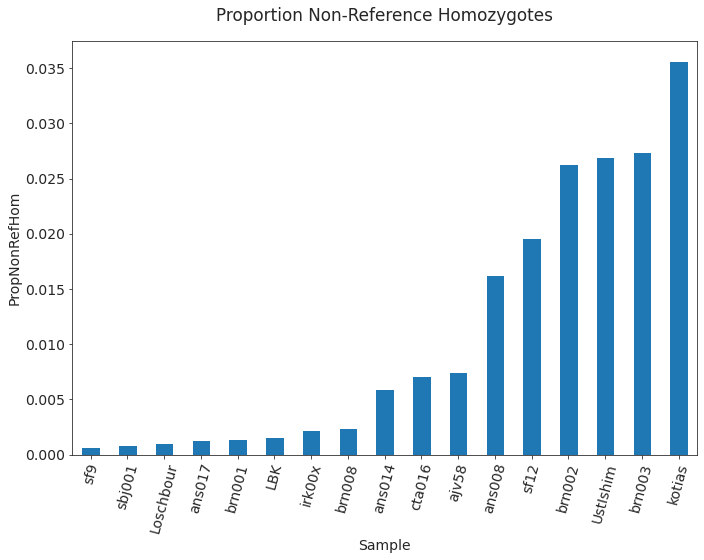

In [298]:
nPropNonRefHom_sorted = stats_df.sort_values(['PropNonRefHom'], ascending=True)
nPropNonRefHom_sorted.plot(kind='bar', x='sample', y='PropNonRefHom', legend=False, capsize=1, rot=75)
plt.title('Proportion Non-Reference Homozygotes', pad=20)
plt.ylabel("PropNonRefHom")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/PropNonRefHom.pdf')

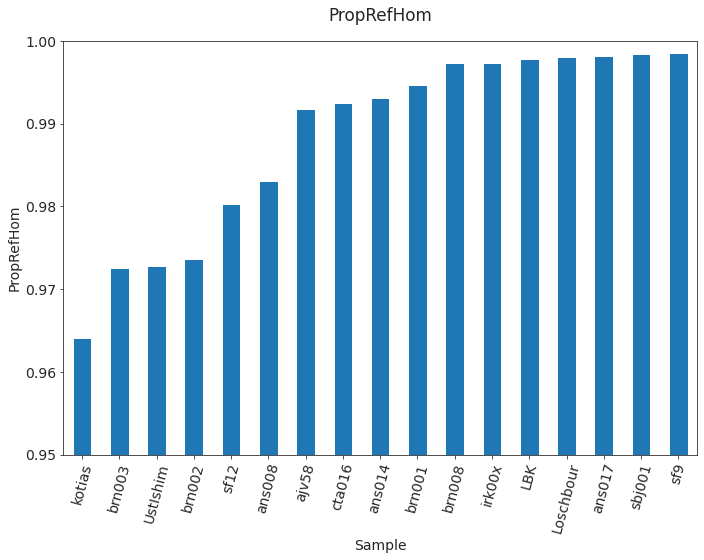

In [299]:
nPropRefHom_sorted = stats_df.sort_values(['PropRefHom'], ascending=True)
nPropRefHom_sorted.plot(kind='bar', x='sample', y='PropRefHom', legend=False, capsize=1, rot=75)
plt.title('PropRefHom', pad=20)
plt.ylabel("PropRefHom")
plt.xlabel("Sample")
plt.ylim([0.95, 1.0])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/PropRefHom.pdf')

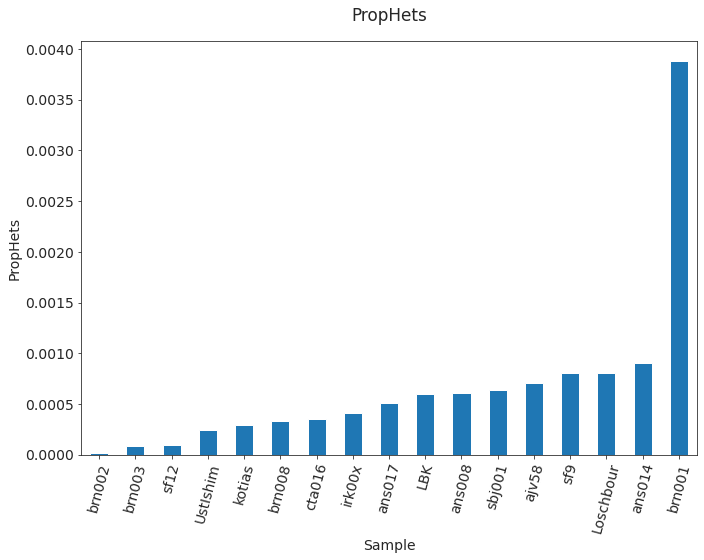

In [300]:
nPropHets_sorted = stats_df.sort_values(['PropHets'], ascending=True)
nPropHets_sorted.plot(kind='bar', x='sample', y='PropHets', legend=False, capsize=1, rot=75)
plt.title('PropHets', pad=20)
plt.ylabel("PropHets")
plt.xlabel("Sample")
#plt.ylim([0.95, 1.0])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/PropHets.pdf')

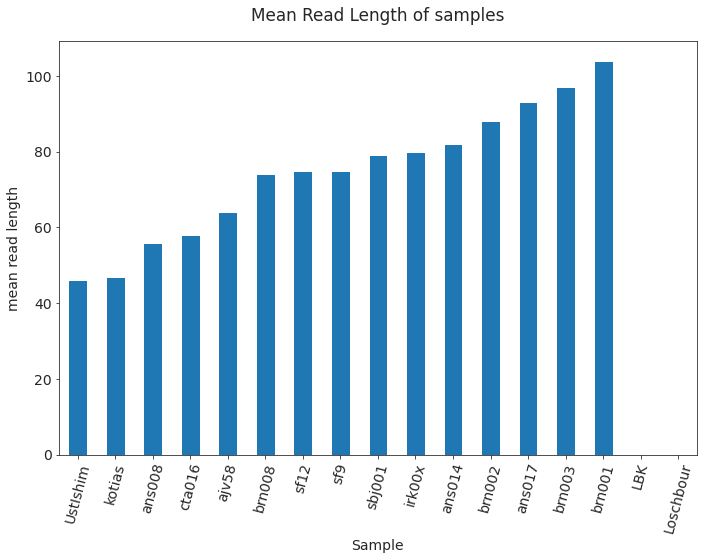

In [301]:
# plot some variables from the table: f2(baa001, X), mReadLength, averageDP etc
mRL_sorted = stats_df.sort_values(['mReadLength'], ascending=True)
mRL_sorted.plot(kind='bar', x='sample', y='mReadLength', legend=False, capsize=1, rot=75)
plt.title('Mean Read Length of samples', pad=20)
plt.ylabel("mean read length")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/averageReadLength.pdf')

# Plot key variables against sample coverage 

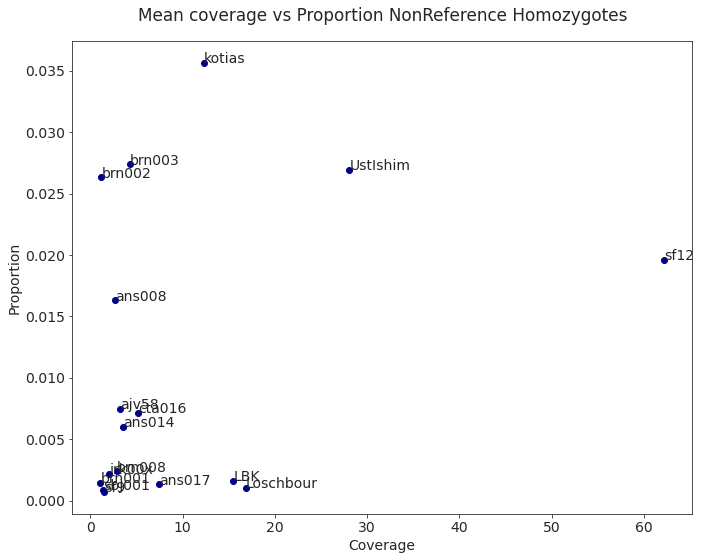

In [302]:
# open figure + axis
fig, ax = plt.subplots()
# plot
ax.scatter(x=stats_df['averageDP'],y=stats_df['PropNonRefHom'],c='DarkBlue')
# set labels
ax.set_title('Mean coverage vs Proportion NonReference Homozygotes', pad=20)
ax.set_xlabel('Coverage')
ax.set_ylabel('Proportion')

# annotate points in axis
for idx, row in stats_df.iterrows():
    ax.annotate(row['sample'], (row['averageDP'], row['PropNonRefHom']) )
# force matplotlib to draw the graph
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Coverage_vs_PropNonRefHomozygotes.pdf')

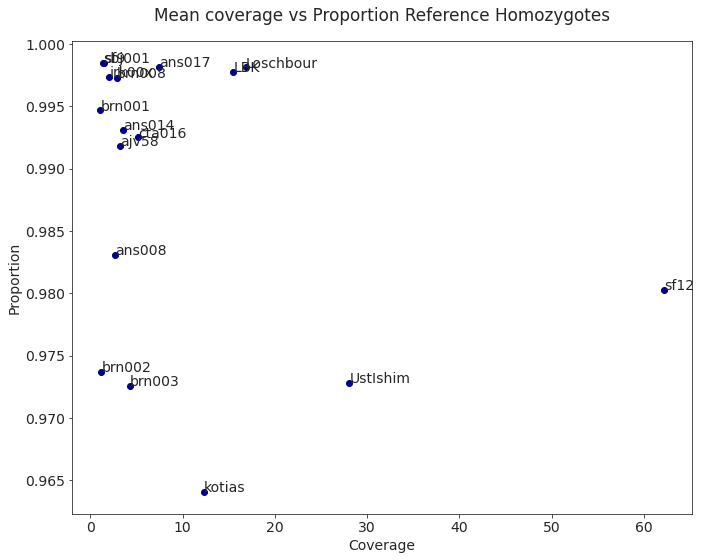

In [303]:
# open figure + axis
fig, ax = plt.subplots()
# plot
ax.scatter(x=stats_df['averageDP'],y=stats_df['PropRefHom'],c='DarkBlue')
# set labels
ax.set_title('Mean coverage vs Proportion Reference Homozygotes', pad=20)
ax.set_xlabel('Coverage')
ax.set_ylabel('Proportion')

# annotate points in axis
for idx, row in stats_df.iterrows():
    ax.annotate(row['sample'], (row['averageDP'], row['PropRefHom']) )
# force matplotlib to draw the graph
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Coverage_vs_PropRefHomozygotes.pdf')

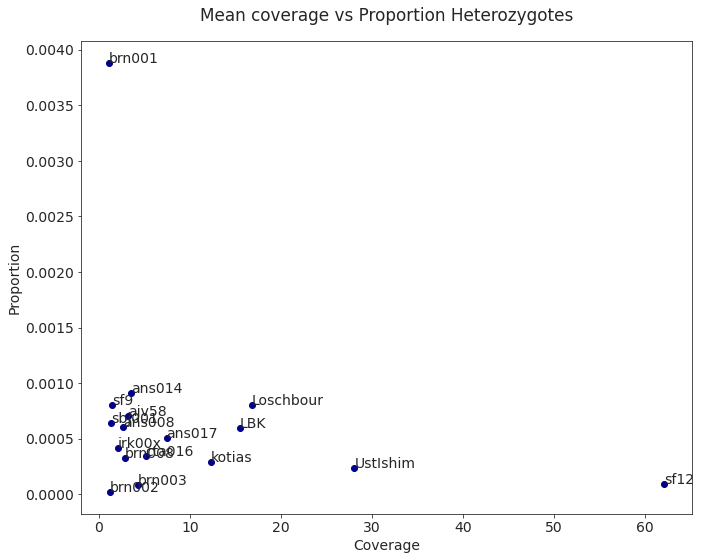

In [304]:
# open figure + axis
fig, ax = plt.subplots()
# plot
ax.scatter(x=stats_df['averageDP'],y=stats_df['PropHets'],c='DarkBlue')
# set labels
ax.set_title('Mean coverage vs Proportion Heterozygotes', pad=20)
ax.set_xlabel('Coverage')
ax.set_ylabel('Proportion')

# annotate points in axis
for idx, row in stats_df.iterrows():
    ax.annotate(row['sample'], (row['averageDP'], row['PropHets']) )
# force matplotlib to draw the graph
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Coverage_vs_PropHeterozygotes.pdf')

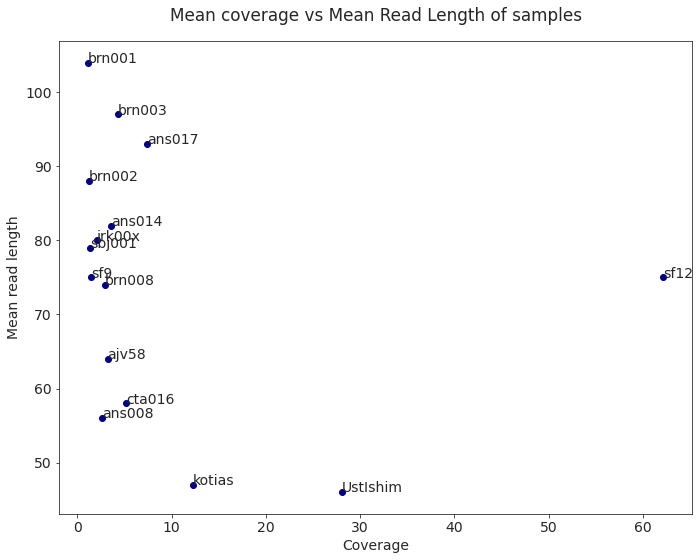

In [305]:
# open figure + axis
fig, ax = plt.subplots()
# plot
ax.scatter(x=stats_df['averageDP'],y=stats_df['mReadLength'],c='DarkBlue')
# set labels
ax.set_title('Mean coverage vs Mean Read Length of samples', pad=20)
ax.set_xlabel('Coverage')
ax.set_ylabel('Mean read length')

# annotate points in axis
for idx, row in stats_df.iterrows():
    ax.annotate(row['sample'], (row['averageDP'], row['mReadLength']) )
# force matplotlib to draw the graph
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Coverage_vs_MeanReadLength.pdf')

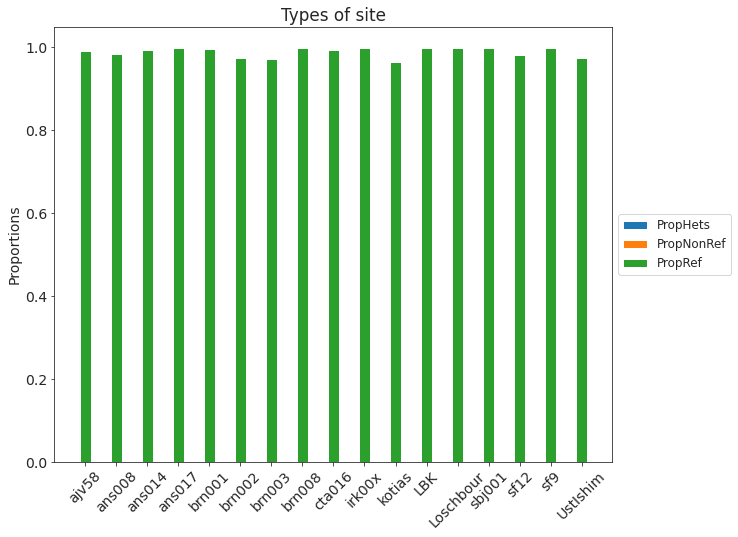

In [306]:
# looking at different type of site per individual in a stacked bar chart
labels = stats_df['sample'].tolist()
PropHets = stats_df['PropHets'].tolist()
PropNonRef = stats_df['PropNonRefHom'].tolist()
PropRef = stats_df['PropRefHom'].tolist()

width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, PropHets, width, label='PropHets')
ax.bar(labels, PropNonRef, width, label='PropNonRef')
ax.bar(labels, PropRef, width, label='PropRef')

ax.set_ylabel('Proportions')
ax.set_title('Types of site')
plt.xticks(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [307]:
# Previously I have plotted the proportion of transitions that are derived, and the proportion of transversions that are derived.
# Now plot the proportion of derived that are transitions / transversions per sample

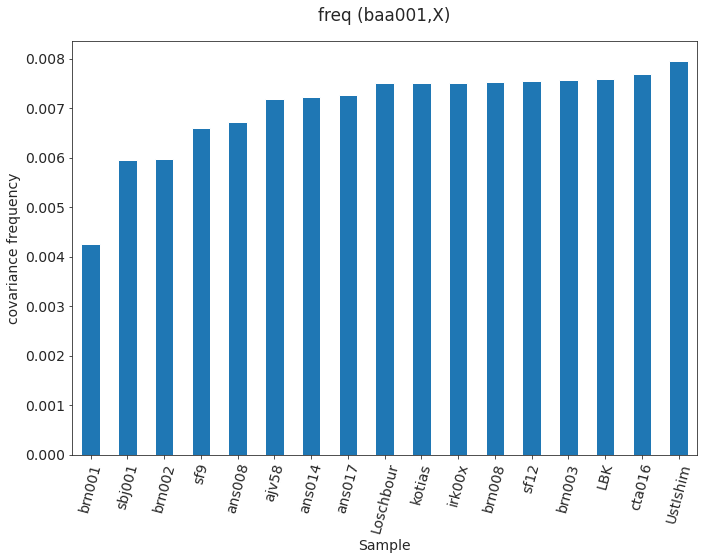

In [308]:
# plot some variables from the table: f2(baa001, X), mReadLength, averageDP etc
freq_baa001_sorted = stats_df.sort_values(['freq(baa,X)'], ascending=True)
freq_baa001_sorted.plot(kind='bar', x='sample', y='freq(baa,X)', legend=False, capsize=1, rot=75)
plt.title('freq (baa001,X)', pad=20)
plt.ylabel("covariance frequency")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/freq_baa001_X.pdf')

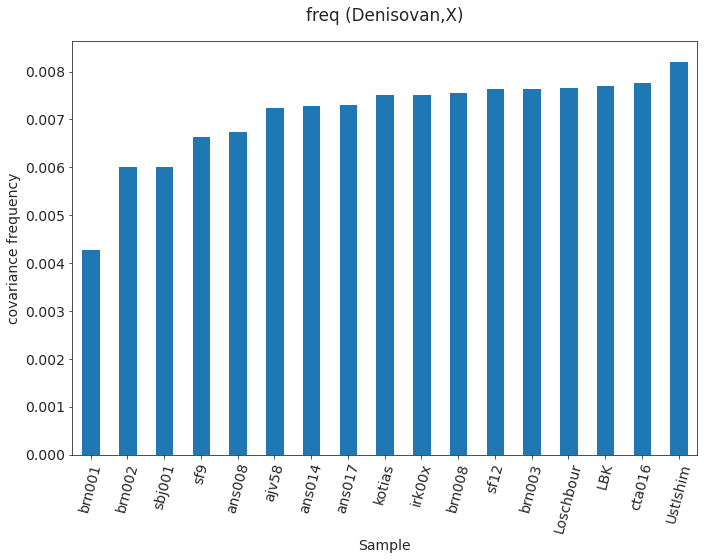

In [309]:
# plot some variables from the table: f2(baa001, X), mReadLength, averageDP etc
freq_baa001_sorted = stats_df.sort_values(['freq(Denisovan,X)'], ascending=True)
freq_baa001_sorted.plot(kind='bar', x='sample', y='freq(Denisovan,X)', legend=False, capsize=1, rot=75)
plt.title('freq (Denisovan,X)', pad=20)
plt.ylabel("covariance frequency")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/freq_Denisovan_X.pdf')

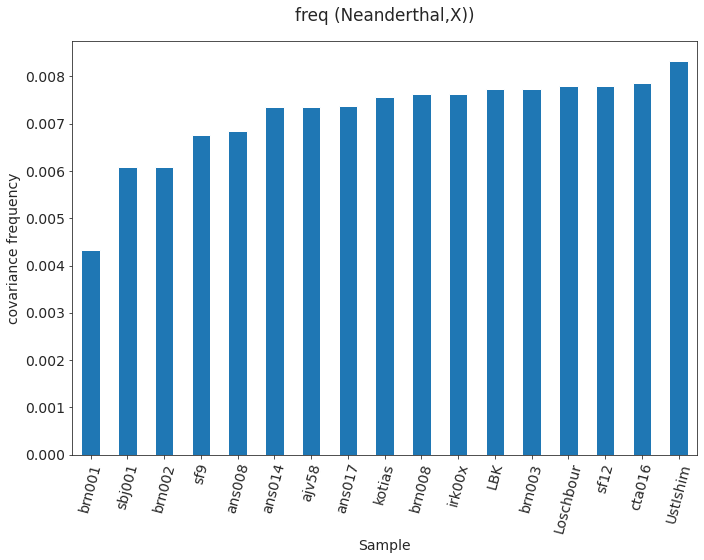

In [310]:
# plot some variables from the table: f2(baa001, X), mReadLength, averageDP etc
freq_baa001_sorted = stats_df.sort_values(['freq(Neanderthal,X)'], ascending=True)
freq_baa001_sorted.plot(kind='bar', x='sample', y='freq(Neanderthal,X)', legend=False, capsize=1, rot=75)
plt.title('freq (Neanderthal,X))', pad=20)
plt.ylabel("covariance frequency")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/freq_Neanderthal_X.pdf')

### Specifically we are interested in correlations between anchor stat and all other variables
### What correlates with the proportion derived for transversions?

In [311]:
stats_df.corr()['baa001_anchor_prop_der_tv']

nRefHom                             -0.034718
nNonRefHom                          -0.212816
nHets                                0.256877
nTransitions                        -0.145734
nTransversions                      -0.135157
ts/tv ratio                         -0.106442
averageDP                           -0.011823
nSingletons                         -0.160675
nMissing                             0.036832
Sample_time                          0.070715
Contamination                       -0.133264
mReadLength                          0.049297
f2(baa001,X)                         0.351826
f2(Denisovan,X)                      0.351963
f2(Neanderthal,X)                    0.352750
f3(Denisovan;baa001,X)              -0.527389
f3(Neanderthal;baa001,X)            -0.529185
unnormed_f3(Denisovan;baa001,X)     -0.433632
unnormed_f3(Neanderthal;baa001,X)   -0.422816
SequenceDiversity                   -0.130483
SegSites                            -0.130290
HeterozygosityObs                 

### What correlates with the proportion derived for transitions?

In [312]:
stats_df.corr()['baa001_anchor_prop_der_ts']

nRefHom                             -0.100647
nNonRefHom                           0.164662
nHets                               -0.188312
nTransitions                         0.080457
nTransversions                       0.255477
ts/tv ratio                          0.000439
averageDP                            0.548343
nSingletons                          0.136274
nMissing                             0.099652
Sample_time                          0.282664
Contamination                       -0.164312
mReadLength                         -0.204784
f2(baa001,X)                        -0.478970
f2(Denisovan,X)                     -0.480017
f2(Neanderthal,X)                   -0.478447
f3(Denisovan;baa001,X)               0.711170
f3(Neanderthal;baa001,X)             0.707098
unnormed_f3(Denisovan;baa001,X)      0.523439
unnormed_f3(Neanderthal;baa001,X)    0.489678
SequenceDiversity                    0.602079
SegSites                             0.600399
HeterozygosityObs                 

## As an added "test" of what the most important features are, we can do a quick linear regression to see what is driving the anchor stats.
## Note that clearly many of the features I have are highly correlated

In [313]:
# Can do a simple linear regression to see the variables most important in predicting anchor statistic 
# doesn't accept NaN values, so need to remove meanReadlength as a variable from the model
from sklearn import linear_model
# Put the target in another DataFrame
target = pd.DataFrame(stats_df, columns=["baa001_anchor_prop_der_tv"])
# Normalize the features
reg_df = stats_df.iloc[:,1:].copy(deep=True)
reg_df.drop(columns=['mReadLength','baa001_anchor_prop_der_tv','baa001_anchor_prop_der_all','baa001_anchor_prop_der_ts'], inplace=True)
X = (reg_df - reg_df.mean())/reg_df.std()
y = target
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)

In [314]:
#R² of the model; percentage of explained variance of the predictions 
lm.score(X,y)

1.0

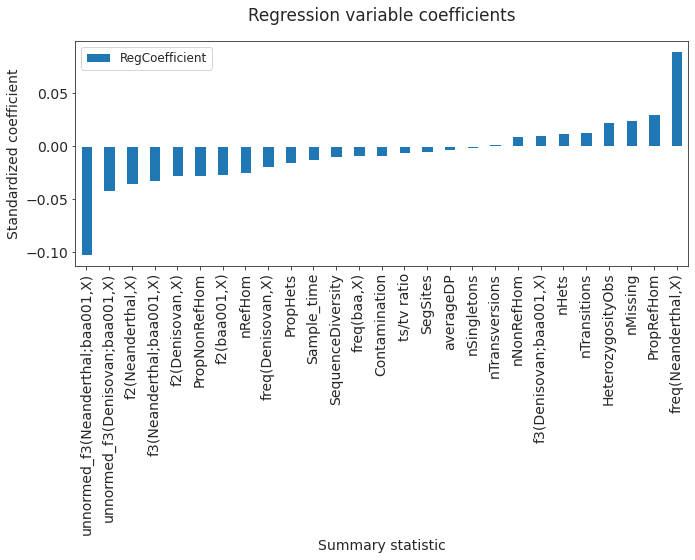

In [315]:
var_importance = lm.coef_.tolist()[0] # coefficients of the predictors
feature_list = reg_df.columns.tolist()
var_reg = pd.DataFrame(list(zip(feature_list, var_importance)), columns=['SummaryStat','RegCoefficient'])

var_reg = var_reg.sort_values(['RegCoefficient'], ascending=True)
var_reg.plot(kind='bar', y='RegCoefficient', x='SummaryStat')
plt.title('Regression variable coefficients', pad=20)
plt.ylabel("Standardized coefficient")
plt.xlabel("Summary statistic")
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/baa001_Linear_regression_variable_coefficients.pdf')

### One option we can do is try to calibrate against a 'known' outgroup, for which we expect no biological effect on the anchor statistic.
### Basically saying; any cline we see in anchor is due to sequencing related technical artefacts/noise in the individuals, so we aim to get rid of that effect in other anchors too.

In [316]:
baa001_anchor_all_mean = stats_df['baa001_anchor_prop_der_all'].mean()
baa001_anchor_ts_mean = stats_df['baa001_anchor_prop_der_ts'].mean()
baa001_anchor_tv_mean = stats_df['baa001_anchor_prop_der_tv'].mean()
stats_df['baa001_anchor_calibration_weight_all'] = stats_df['baa001_anchor_prop_der_all'] / baa001_anchor_all_mean
stats_df['baa001_anchor_calibration_weight_ts'] = stats_df['baa001_anchor_prop_der_ts'] / baa001_anchor_ts_mean
stats_df['baa001_anchor_calibration_weight_tv'] = stats_df['baa001_anchor_prop_der_tv'] / baa001_anchor_tv_mean

### Add new anchor to the dataframe

In [317]:
new_anchor = 'cta016'
new_anchor_prop_der_all = pd.read_csv(outPATH+new_anchor+'_prop_der.res', sep="\t")
new_anchor_prop_der_all['wbj_errors']=2.0*np.sqrt(new_anchor_prop_der_all['wbj_var'])

new_anchor_prop_der_ts = pd.read_csv(outPATH+new_anchor+'_prop_der_transition.res', sep="\t")
new_anchor_prop_der_ts['wbj_errors']=2.0*np.sqrt(new_anchor_prop_der_ts['wbj_var'])

new_anchor_prop_der_tv = pd.read_csv(outPATH+new_anchor+'_prop_der_transversion.res', sep="\t")
new_anchor_prop_der_tv['wbj_errors']=2.0*np.sqrt(new_anchor_prop_der_tv['wbj_var'])

In [318]:
# Add these to your sumstats table
stats_df = pd.merge(stats_df,new_anchor_prop_der_all[['sample','wbj_mean','wbj_errors']], on="sample", how = 'left')
stats_df.rename(columns={"wbj_mean":"new_anchor_prop_der_all", "wbj_errors":"new_anchor_prop_der_all_wbjerrs"}, inplace=True)
stats_df = pd.merge(stats_df,new_anchor_prop_der_ts[['sample','wbj_mean','wbj_errors']], on="sample", how = 'left')
stats_df.rename(columns={"wbj_mean":"new_anchor_prop_der_ts", "wbj_errors":"new_anchor_prop_der_ts_wbjerrs"}, inplace=True)
stats_df = pd.merge(stats_df,new_anchor_prop_der_tv[['sample','wbj_mean','wbj_errors']], on="sample", how = 'left')
stats_df.rename(columns={"wbj_mean":"new_anchor_prop_der_tv", "wbj_errors":"new_anchor_prop_der_tv_wbjerrs"}, inplace=True)

### Calibrate new anchor results using baa001 calibration weights

In [319]:
# calibrate 
stats_df['new_anchor_prop_der_all_calibrated'] = stats_df['new_anchor_prop_der_all'] / stats_df['baa001_anchor_calibration_weight_all']
stats_df['new_anchor_prop_der_ts_calibrated'] = stats_df['new_anchor_prop_der_ts'] / stats_df['baa001_anchor_calibration_weight_ts']
stats_df['new_anchor_prop_der_tv_calibrated'] = stats_df['new_anchor_prop_der_tv'] / stats_df['baa001_anchor_calibration_weight_tv']

### Plot results and calibrated results for all sites, transitions, transversions

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


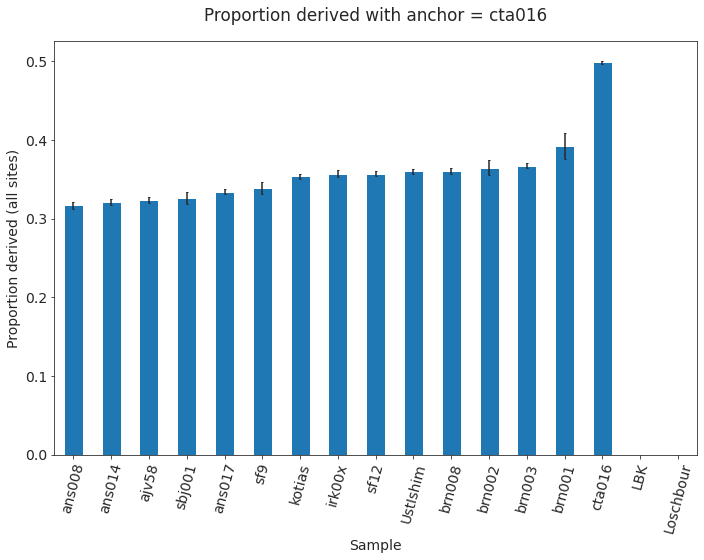

In [320]:
sorted_all = stats_df.sort_values(['new_anchor_prop_der_all'], ascending=True)
sorted_all.plot(kind='bar', x='sample', y='new_anchor_prop_der_all', legend=False, yerr='new_anchor_prop_der_all_wbjerrs', capsize=1, rot=75)
plt.title('Proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (all sites)")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Prop_der_'+new_anchor+'_allSites_ALLINDS.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


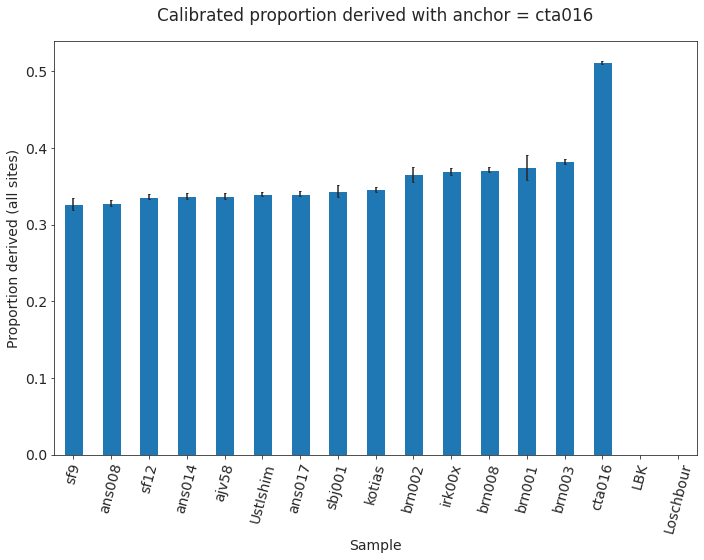

In [321]:
sorted_all_calibrated = stats_df.sort_values(['new_anchor_prop_der_all_calibrated'], ascending=True)
sorted_all_calibrated.plot(kind='bar', x='sample', y='new_anchor_prop_der_all_calibrated', legend=False, yerr='new_anchor_prop_der_all_wbjerrs', capsize=1, rot=75)
plt.title('Calibrated proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (all sites)")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Cal_prop_der_'+new_anchor+'_allSites_ALLINDS.pdf')

### If we just focus on the Scandinavian samples (with LBK = farmer and Loschbour = WHG)

In [322]:
scandi_samples = ['LBK','Loschbour', 'sf12', 'sf9', 'sbj001', 'ans017', 'ans014', 'ans008', 'ajv58']
#scandi_samples = ['sf12', 'sf9', 'sbj001', 'ans017', 'ans014', 'ans008', 'ajv58']

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


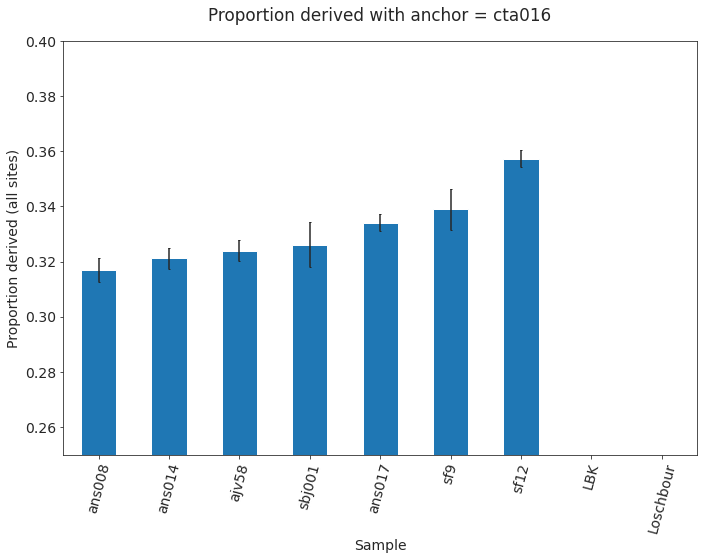

In [323]:
sorted_all = stats_df.loc[stats_df['sample'].isin(scandi_samples)].sort_values(['new_anchor_prop_der_all'], ascending=True)
sorted_all.plot(kind='bar', x='sample', y='new_anchor_prop_der_all', legend=False, yerr='new_anchor_prop_der_all_wbjerrs', capsize=1, rot=75)
plt.title('Proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (all sites)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.40])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Prop_der_'+new_anchor+'_allSites_Scandis.pdf')   

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


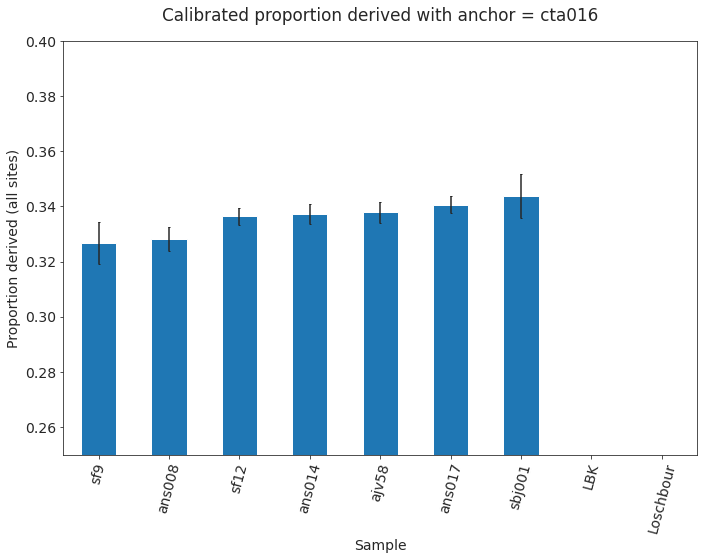

In [324]:
sorted_all_calibrated = stats_df.loc[stats_df['sample'].isin(scandi_samples)].sort_values(['new_anchor_prop_der_all_calibrated'], ascending=True)
sorted_all_calibrated.plot(kind='bar', x='sample', y='new_anchor_prop_der_all_calibrated', legend=False, yerr='new_anchor_prop_der_all_wbjerrs', capsize=1, rot=75)
plt.title('Calibrated proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (all sites)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.40])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Cal_prop_der_'+new_anchor+'_allSites_Scandis.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


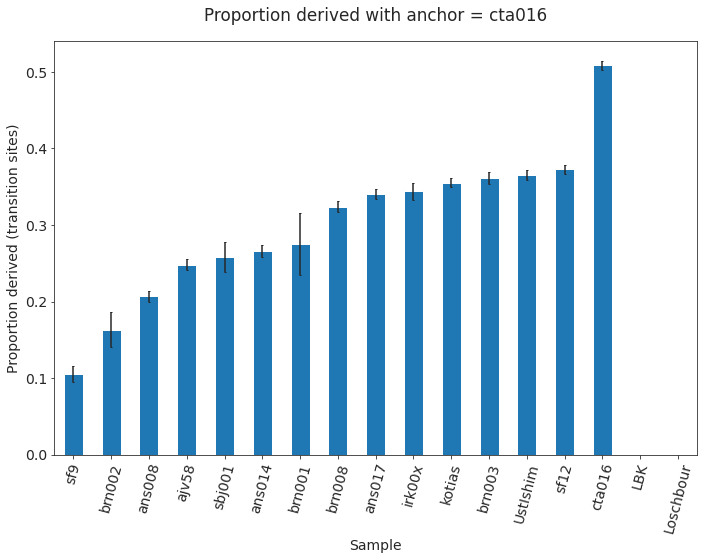

In [325]:
sorted_ts = stats_df.sort_values(['new_anchor_prop_der_ts'], ascending=True)
sorted_ts.plot(kind='bar', x='sample', y='new_anchor_prop_der_ts', legend=False, yerr='new_anchor_prop_der_ts_wbjerrs', capsize=1, rot=75)
plt.title('Proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transition sites)")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Prop_der_'+new_anchor+'_tsSites.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


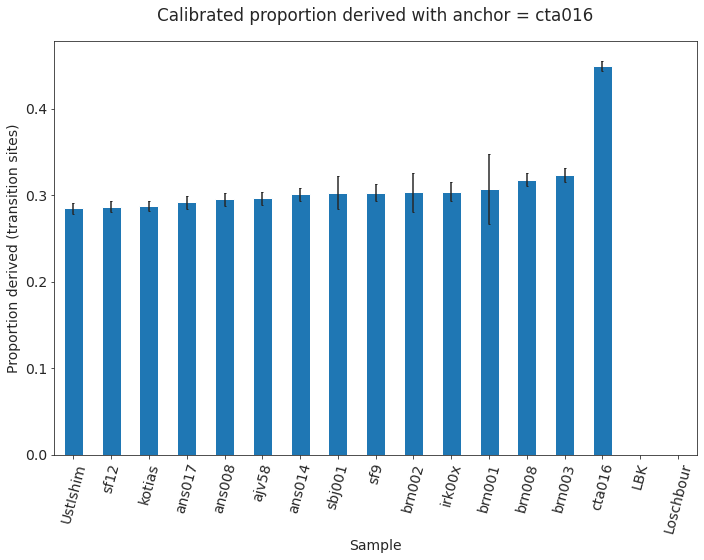

In [326]:
sorted_ts_calibrated = stats_df.sort_values(['new_anchor_prop_der_ts_calibrated'], ascending=True)
sorted_ts_calibrated.plot(kind='bar', x='sample', y='new_anchor_prop_der_ts_calibrated', legend=False, yerr='new_anchor_prop_der_ts_wbjerrs', capsize=1, rot=75)
plt.title('Calibrated proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transition sites)")
plt.xlabel("Sample")
#plt.ylim([0.20, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Cal_prop_der_'+new_anchor+'_tsSites.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


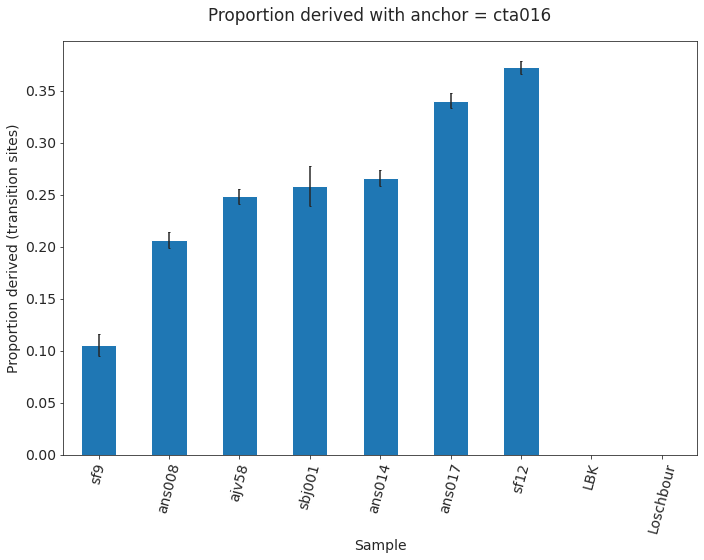

In [327]:
sorted_ts = stats_df.loc[stats_df['sample'].isin(scandi_samples)].sort_values(['new_anchor_prop_der_ts'], ascending=True)
sorted_ts.plot(kind='bar', x='sample', y='new_anchor_prop_der_ts', legend=False, yerr='new_anchor_prop_der_ts_wbjerrs', capsize=1, rot=75)
plt.title('Proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transition sites)")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Prop_der_'+new_anchor+'_tsSites_Scandis.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


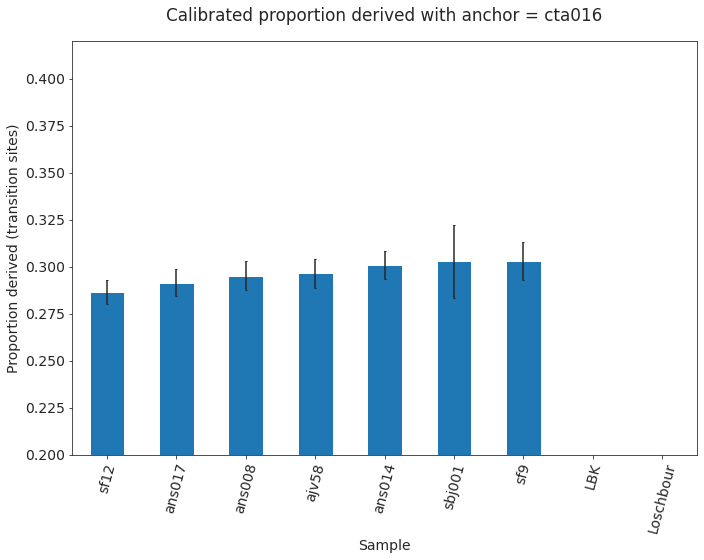

In [328]:
sorted_ts_calibrated = stats_df.loc[stats_df['sample'].isin(scandi_samples)].sort_values(['new_anchor_prop_der_ts_calibrated'], ascending=True)
sorted_ts_calibrated.plot(kind='bar', x='sample', y='new_anchor_prop_der_ts_calibrated', legend=False, yerr='new_anchor_prop_der_ts_wbjerrs', capsize=1, rot=75)
plt.title('Calibrated proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transition sites)")
plt.xlabel("Sample")
plt.ylim([0.20, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Cal_prop_der_'+new_anchor+'_tsSites_Scandis.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


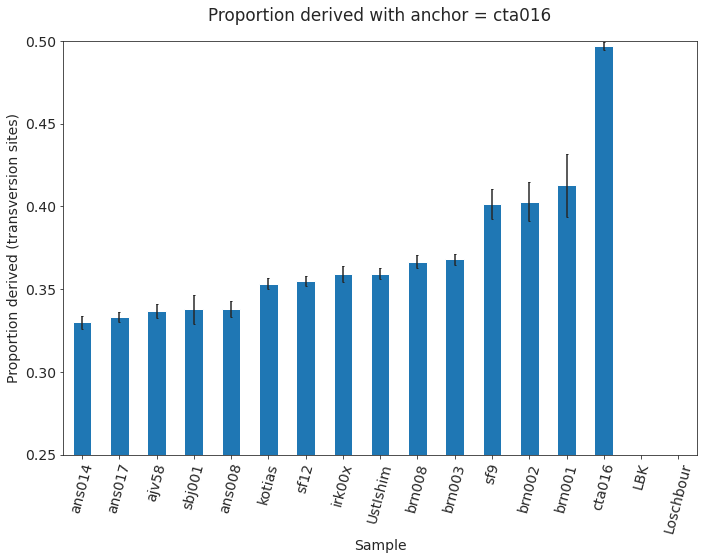

In [329]:
sorted_tv = stats_df.sort_values(['new_anchor_prop_der_tv'], ascending=True)
sorted_tv.plot(kind='bar', x='sample', y='new_anchor_prop_der_tv', legend=False, yerr='new_anchor_prop_der_tv_wbjerrs', capsize=1, rot=75)
plt.title('Proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transversion sites)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.50])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Prop_der_'+new_anchor+'_tvSites.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


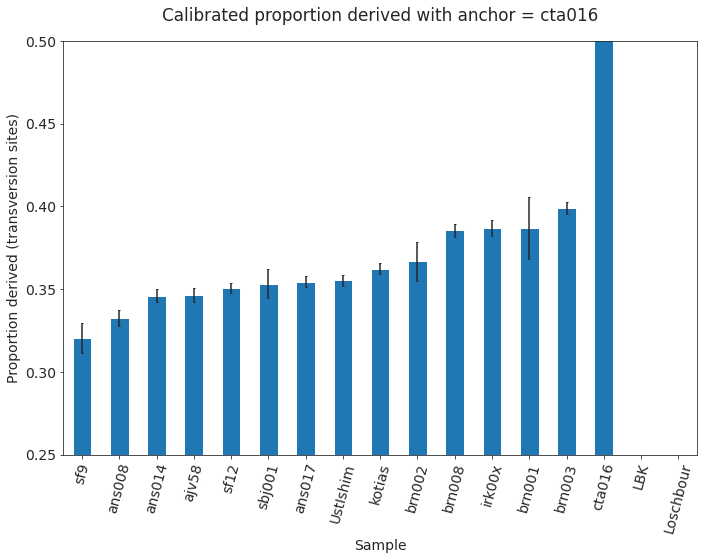

In [330]:
sorted_tv_calibrated = stats_df.sort_values(['new_anchor_prop_der_tv_calibrated'], ascending=True)
sorted_tv_calibrated.plot(kind='bar', x='sample', y='new_anchor_prop_der_tv_calibrated', legend=False, yerr='new_anchor_prop_der_tv_wbjerrs', capsize=1, rot=75)
plt.title('Calibrated proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transversion sites)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.50])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Cal_prop_der_'+new_anchor+'_tvSites.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


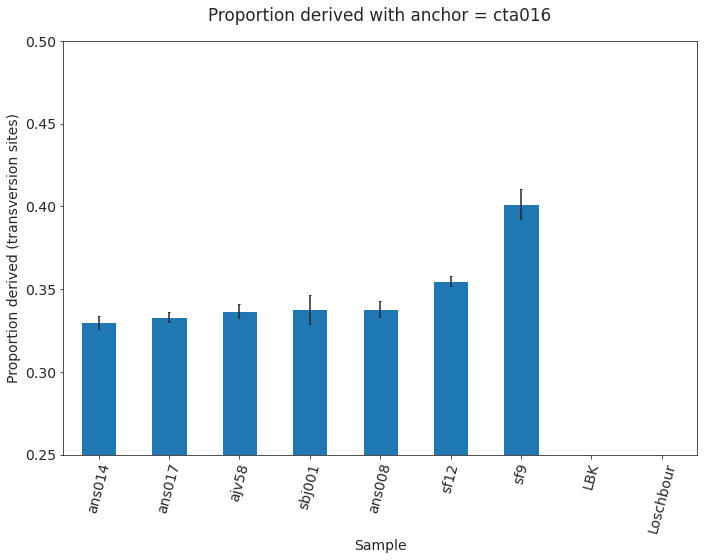

In [331]:
sorted_tv = stats_df.loc[stats_df['sample'].isin(scandi_samples)].sort_values(['new_anchor_prop_der_tv'], ascending=True)
sorted_tv.plot(kind='bar', x='sample', y='new_anchor_prop_der_tv', legend=False, yerr='new_anchor_prop_der_tv_wbjerrs', capsize=1, rot=75)
plt.title('Proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transversion sites)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.5])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Prop_der_'+new_anchor+'_tvSites_Scandis.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


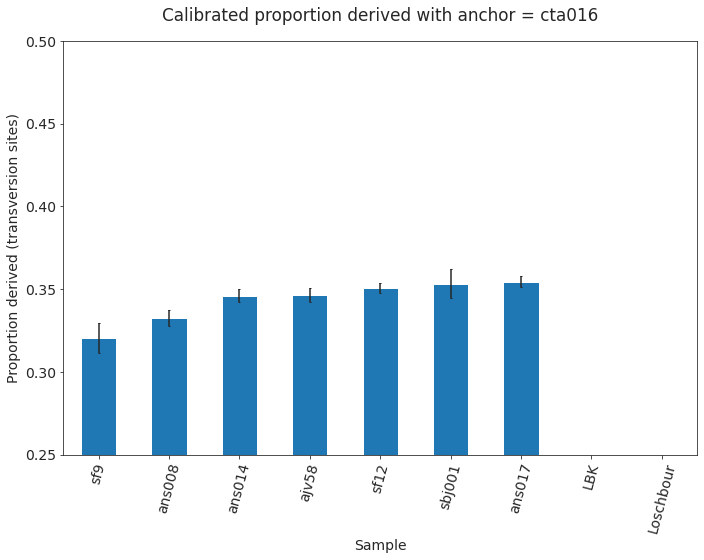

In [332]:
sorted_tv_calibrated = stats_df.loc[stats_df['sample'].isin(scandi_samples)].sort_values(['new_anchor_prop_der_tv_calibrated'], ascending=True)
sorted_tv_calibrated.plot(kind='bar', x='sample', y='new_anchor_prop_der_tv_calibrated', legend=False, yerr='new_anchor_prop_der_tv_wbjerrs', capsize=1, rot=75)
plt.title('Calibrated proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transversion sites)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.50])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Cal_prop_der_'+new_anchor+'_tvSites_Scandis.pdf')

### Now we can switch attention to the Siberian samples (Loschbour = WHG)

In [333]:
siberian_samples = ['Loschbour', 'irk078', 'irk00x', 'cta016', 'brn008', 'brn003', 'brn002', 'brn001']

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


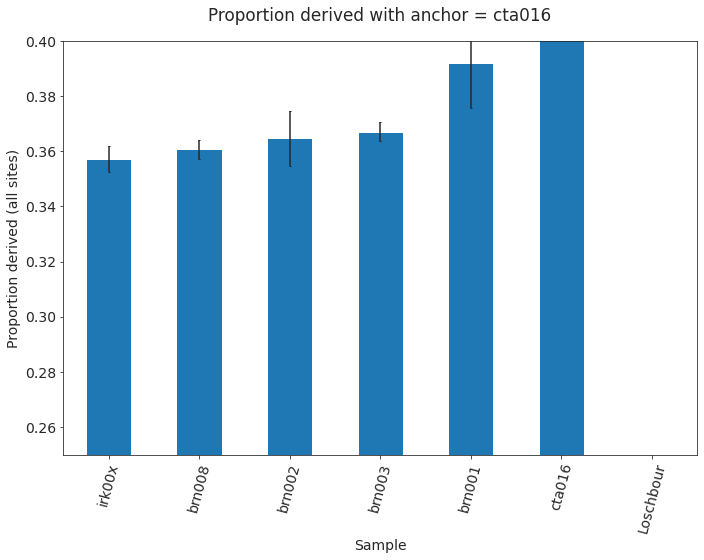

In [334]:
sorted_all = stats_df.loc[stats_df['sample'].isin(siberian_samples)].sort_values(['new_anchor_prop_der_all'], ascending=True)
sorted_all.plot(kind='bar', x='sample', y='new_anchor_prop_der_all', legend=False, yerr='new_anchor_prop_der_all_wbjerrs', capsize=1, rot=75)
plt.title('Proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (all sites)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.40])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Prop_der_'+new_anchor+'_allSites_Siberian.pdf')  

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


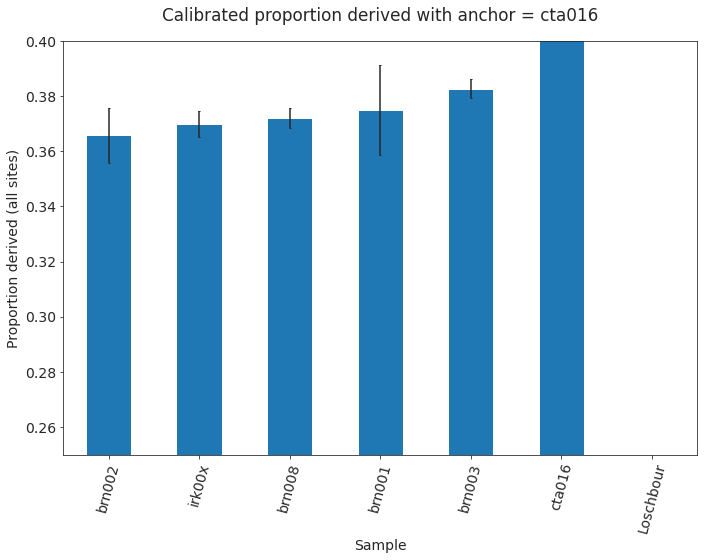

In [335]:
sorted_all_calibrated = stats_df.loc[stats_df['sample'].isin(siberian_samples)].sort_values(['new_anchor_prop_der_all_calibrated'], ascending=True)
sorted_all_calibrated.plot(kind='bar', x='sample', y='new_anchor_prop_der_all_calibrated', legend=False, yerr='new_anchor_prop_der_all_wbjerrs', capsize=1, rot=75)
plt.title('Calibrated proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (all sites)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.40])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Cal_prop_der_'+new_anchor+'_allSites_Siberian.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


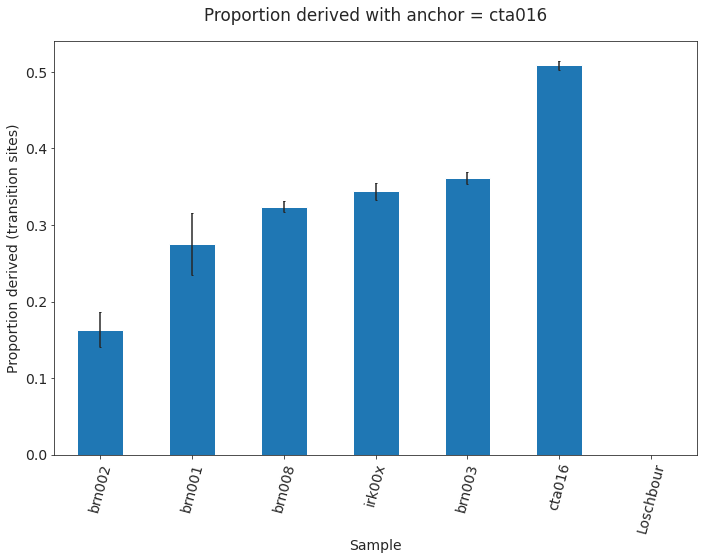

In [336]:
sorted_ts = stats_df.loc[stats_df['sample'].isin(siberian_samples)].sort_values(['new_anchor_prop_der_ts'], ascending=True)
sorted_ts.plot(kind='bar', x='sample', y='new_anchor_prop_der_ts', legend=False, yerr='new_anchor_prop_der_ts_wbjerrs', capsize=1, rot=75)
plt.title('Proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transition sites)")
plt.xlabel("Sample")
#plt.ylim([0.30, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Prop_der_'+new_anchor+'_tsSites_Siberian.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


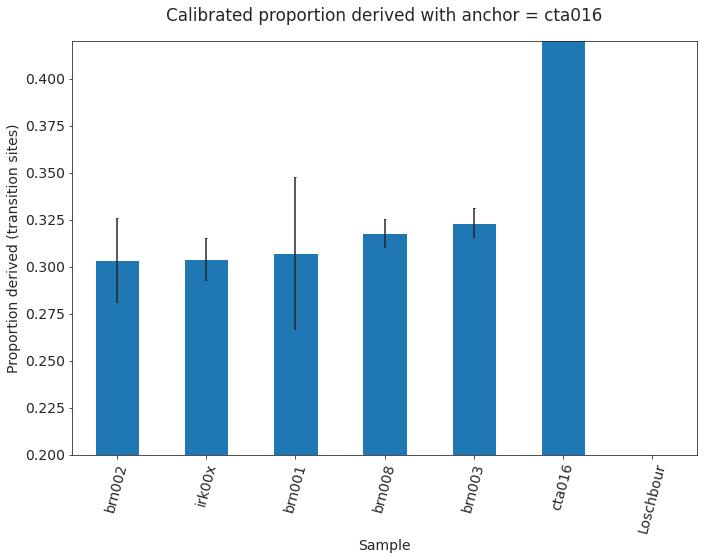

In [337]:
sorted_ts_calibrated = stats_df.loc[stats_df['sample'].isin(siberian_samples)].sort_values(['new_anchor_prop_der_ts_calibrated'], ascending=True)
sorted_ts_calibrated.plot(kind='bar', x='sample', y='new_anchor_prop_der_ts_calibrated', legend=False, yerr='new_anchor_prop_der_ts_wbjerrs', capsize=1, rot=75)
plt.title('Calibrated proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transition sites)")
plt.xlabel("Sample")
plt.ylim([0.20, 0.42])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Cal_prop_der_'+new_anchor+'_tsSites_Siberian.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


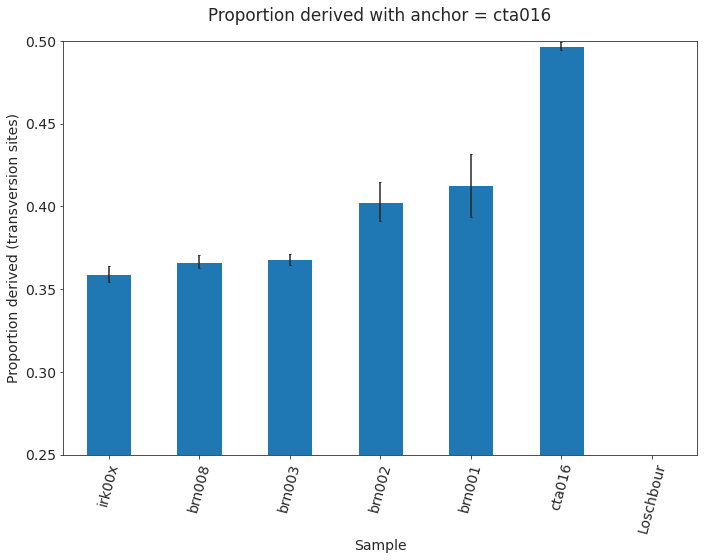

In [338]:
sorted_tv = stats_df.loc[stats_df['sample'].isin(siberian_samples)].sort_values(['new_anchor_prop_der_tv'], ascending=True)
sorted_tv.plot(kind='bar', x='sample', y='new_anchor_prop_der_tv', legend=False, yerr='new_anchor_prop_der_tv_wbjerrs', capsize=1, rot=75)
plt.title('Proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transversion sites)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.5])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Prop_der_'+new_anchor+'_tvSites_Siberian.pdf')

/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/jamesmckenna/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


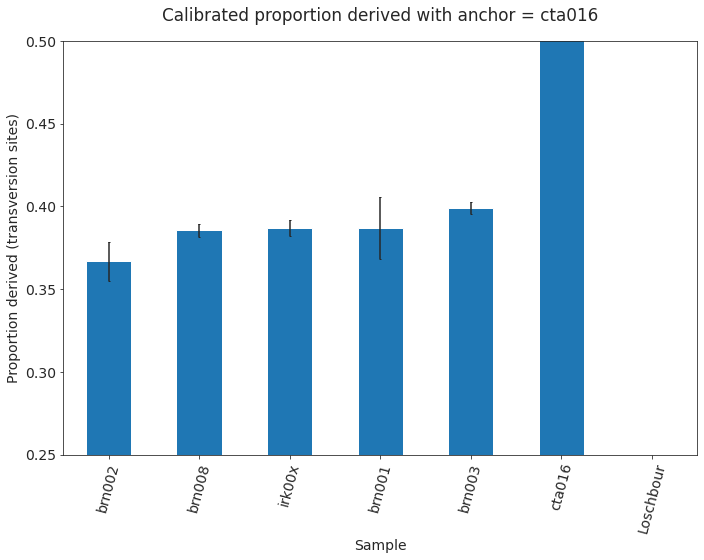

In [339]:
sorted_tv_calibrated = stats_df.loc[stats_df['sample'].isin(siberian_samples)].sort_values(['new_anchor_prop_der_tv_calibrated'], ascending=True)
sorted_tv_calibrated.plot(kind='bar', x='sample', y='new_anchor_prop_der_tv_calibrated', legend=False, yerr='new_anchor_prop_der_tv_wbjerrs', capsize=1, rot=75)
plt.title('Calibrated proportion derived with anchor = {}'.format(new_anchor), pad=20)
plt.ylabel("Proportion derived (transversion sites)")
plt.xlabel("Sample")
plt.ylim([0.25, 0.50])
plt.tight_layout()
if isSaveFigures:
    plt.savefig('DIR_plots/Cal_prop_der_'+new_anchor+'_tvSites_Siberian.pdf')